In [60]:
import pandas as pd

from datetime import datetime
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, plot_confusion_matrix, precision_score, recall_score,classification_report,make_scorer

import shap
import dataframe_image as dfi
import cv2

In [61]:
df_train = pd.read_csv('../Data/UNSW_NB15_training-set.csv')
df_test = pd.read_csv('../Data/UNSW_NB15_testing-set.csv')

```
Multi Class
```

In [62]:
df_train = df_train.drop(['label','id'], axis=1)
df_test = df_test.drop(['label','id'], axis=1)

df_train = df_train.drop_duplicates(keep='first').reset_index(drop=True)
df_test = df_test.drop_duplicates(keep='first').reset_index(drop=True)

global categorical_features_train, categorical_features_test
categorical_features_train = list(df_train.select_dtypes(include=['object']).columns)
categorical_features_test = list(df_test.select_dtypes(include=['object']).columns)

global numerical_features_train, numerical_features_test
numerical_features_train = list(df_train.select_dtypes(exclude=['object']).columns)
numerical_features_test = list(df_test.select_dtypes(exclude=['object']).columns)

In [63]:
lab_enc_df_train = df_train.copy()
lab_enc_df_test = df_test.copy()

labelencoder = LabelEncoder()

for c in categorical_features_train:
    lab_enc_df_train[c] = labelencoder.fit_transform(lab_enc_df_train[c])

for c in categorical_features_test:
    lab_enc_df_test[c] = labelencoder.fit_transform(lab_enc_df_test[c])

scaled_enc_df_train = lab_enc_df_train.copy()
scaled_enc_df_test = lab_enc_df_test.copy()

col_names = numerical_features_train
features = scaled_enc_df_train[col_names]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_enc_df_train[col_names] = features

col_names = numerical_features_test
features = scaled_enc_df_test[col_names]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_enc_df_test[col_names] = features


In [64]:

def MI_topk_features(df_pp, k):

    now = datetime.now()
    print(f'{now} - Mutual Information feature selection Initialized..')

    X = df_pp.iloc[:,:-1]
    y = df_pp.iloc[:,-1]

    importances = mutual_info_classif(X,y)
    feature_imp = pd.Series(importances, df_pp.columns[0:len(df_pp.columns)-1])

    MI_features = list(feature_imp.sort_values(ascending = False)[:k].index)

    now = datetime.now()
    print(f'{now} - Mutual Information feature selection Successful!')

    return MI_features

def CORR_topk_features(df_pp, k):

    now = datetime.now()
    print(f'{now} - Correlation feature selection Initialized..')

    cor = df_pp.corr()
    CORR_features = list(abs(cor['attack_cat']).sort_values(ascending=False)[:k+1].index)
    CORR_features.remove('attack_cat')

    now = datetime.now()
    print(f'{now} - Correlation feature selection Successful!')

    return CORR_features

def RFFI_topk_features(df_pp, k):
    
    now = datetime.now()
    print(f'{now} - RF Feature Importance feature selection Initialized..')

    X = df_pp.iloc[:,:-1]
    y = df_pp.iloc[:,-1]

    rf = RandomForestClassifier(n_estimators=200,random_state=42)
    rf.fit(X.values,y.values)
    rffi = rf.feature_importances_

    features = pd.Series(rffi, df_pp.columns[0:len(df_pp.columns)-1])
    RFFI_features = list(features.sort_values(ascending = False)[:k].index)

    now = datetime.now()
    print(f'{now} - RF Feature Importance feature selection Successful!')

    return RFFI_features

def SHAP_topk_features(df_train, df_test, number_of_instances, k):

    now = datetime.now()
    print(f'{now} - SHAP feature selection Initialized!')

    train_X =  df_train.iloc[:,:-1]
    test_X = df_test.iloc[:,:-1]
    train_y = df_train.iloc[:,-1]
    test_y = df_test.iloc[:,-1]

    rf = RandomForestClassifier(random_state=42).fit(train_X.values,train_y.values)
    shap_df = pd.DataFrame()

    for target in list(train_y.value_counts().index):   
        i = []
        v = []

        for index, value in zip(range(len(train_y)), train_y):    
            i.append(index)
            v.append(value)
        
        y_val = pd.Series(v,i)
        y_val = list(y_val[y_val==target].index)

        idx_threshold = number_of_instances
        final_idx = []

        for idx in y_val:
            if idx_threshold > 0:
                row_instance = train_X.iloc[idx]
                row_pred = row_instance.values.reshape(1, -1)

                if float(rf.predict_proba(row_pred)[0][target]) >= 0.75:
                    final_idx.append(idx)
                    idx_threshold = idx_threshold - 1
            else:
                break

        temp_df = pd.DataFrame()

        for idx in final_idx:
            row_instance = train_X.iloc[idx]
            row_pred = row_instance.values.reshape(1, -1)
            
            explainer = shap.TreeExplainer(rf)
            shap_values = explainer.shap_values(row_instance)

            series_idx = row_instance.index
            series_val = shap_values[target]

            feature_series = pd.Series(series_val, series_idx)
            
            shap_df_temp = feature_series.to_frame().rename(columns={0:'shap_value'}).rename_axis('features').reset_index()
            temp_df = temp_df.append(shap_df_temp, ignore_index = True)

        temp_df = temp_df.sort_values(by=['shap_value'], ascending=False).drop_duplicates(subset='features', keep='first')
        shap_df = shap_df.append(temp_df, ignore_index = True)    

    shap_df = shap_df.sort_values(by=['shap_value'], ascending=False).drop_duplicates(subset='features', keep='first')
    shap_features = list(shap_df['features'].iloc[:k])

    now = datetime.now()
    print(f'{now} - SHAP feature selection Successful!')

    return shap_features

In [65]:
def model_performance(df_train, df_test, features, technique, k, atype='', dataset='UNSW'):

    now = datetime.now()
    print(f'{now} - Model training started!')

    train_X =  df_train.iloc[:,:-1]
    test_X = df_test.iloc[:,:-1]
    train_y = df_train.iloc[:,-1]
    test_y = df_test.iloc[:,-1]

    scorer = {
            'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score, average = 'macro', zero_division = 1),
            'recall': make_scorer(recall_score, average = 'weighted'),
            'f1': make_scorer(f1_score, average = 'weighted')
                }

    param_grid = { 
            'n_estimators': [200, 300, 400],
            'max_depth' : [6,7,8,9,10],
            'criterion' : ['entropy']
    }

    clf = RandomForestClassifier(random_state = 42)

    g_search = RandomizedSearchCV(estimator = clf, 
                            param_distributions = param_grid, 
                            cv = 3, 
                            n_jobs = -1, 
                            scoring=scorer,
                            refit='f1')

    g_search.fit(train_X, train_y)

    n_estimators = g_search.best_params_['n_estimators']
    max_depth = g_search.best_params_['max_depth']
    criterion = g_search.best_params_['criterion']


    clf=RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion, random_state=42)
    clf.fit(train_X.values,train_y.values)
    y_pred=clf.predict(test_X)

    plot_confusion_matrix(clf, test_X, test_y)
    plt.title(f"{technique}_Confusion_Matrix")
    plt.savefig(f"visualization/Figures/{dataset}_{atype}_k{str(k)}_{str(technique)}_Confusion_Matrix.png", dpi=300, bbox_inches='tight')
    
    sk_report = classification_report(
    digits=6,
    y_true=test_y, 
    y_pred=y_pred,
    output_dict=True)

    report_df = pd.DataFrame(sk_report).transpose()
    
    filename = "visualization/Figures/"+dataset+'_'+atype+"_k"+str(k)+'_'+str(technique)+"_Performance_Report" + ".png"
    dfi.export(report_df,filename)

    performance_dictionary={'Technique':[], 'Class':[],'Accuracy':[],'F1_Score':[],'Precision':[],'Recall':[], 'HP_n_estimators':[], 'HP_max_depth':[], 'k':[]}

    f1 = list(f1_score(test_y, y_pred, average=None))
    matrix = confusion_matrix(test_y, y_pred)
    acc = list(matrix.diagonal()/matrix.sum(axis=1))
    pr = list(precision_score(test_y, y_pred, average=None))
    rl = list(recall_score(test_y, y_pred, average=None))

    for i in range(len(f1)):
        performance_dictionary['Technique'].append(technique)
        performance_dictionary['Class'].append(i)
        performance_dictionary['Accuracy'].append(acc[i])
        performance_dictionary['F1_Score'].append(f1[i])
        performance_dictionary['Precision'].append(pr[i])
        performance_dictionary['Recall'].append(rl[i])
        performance_dictionary['HP_n_estimators'].append(n_estimators)
        performance_dictionary['HP_max_depth'].append(max_depth)
        performance_dictionary['k'].append(k)
        

    df = pd.DataFrame.from_dict(performance_dictionary)

    now = datetime.now()
    print(f'{now} - Model performance dataframe created Successfully!')

    return df

In [66]:
def Multi_Class_Performance_BarChart(MI_perf_df, CORR_perf_df, RFFI_perf_df, SHAP_perf_df, metric,k,dataset='KDDCUP'):

    now = datetime.now()
    print(f'{now} - Initializing {str.upper(metric)} MultiClass comparision Bar Chart visualization..')

    plt.rcParams['figure.dpi'] = 150
    X = ['Normal', 'Exploits', 'Fuzzers', 'Reconnaissance', 'Generic', 'DoS',
       'Analysis', 'Backdoor', 'Shellcode', 'Worms']
    
    MI_acc = list(MI_perf_df[metric])
    CORR_acc = list(CORR_perf_df[metric])
    RFFI_acc = list(RFFI_perf_df[metric])
    SHAP_acc = list(SHAP_perf_df[metric])

    df = pd.DataFrame({'MI_acc': MI_acc,
                   'CORR_acc': CORR_acc,
                   'RFFI_acc': RFFI_acc,
                   'SHAP_acc': SHAP_acc
                   }, index=X)
    ax = df.plot.bar(rot=0)

    plt.title(str.upper(metric) + ' PERFORMANCE')
    plt.legend()
    plt.savefig(f"visualization/Figures/{dataset}_MultiClass_k{str(k)}_{metric}_Bar.png", dpi=300, bbox_inches='tight')

    now = datetime.now()
    print(f'{now} - {str.upper(metric)} MultiClass comparision bar chart visualization generated Successfully!')

def Multi_Class_Performance_LineChart(MI_perf_df, CORR_perf_df, RFFI_perf_df, SHAP_perf_df, metric,k,dataset):

    now = datetime.now()
    print(f'{now} - Initializing {str.upper(metric)} MultiClass comparision Line Chart visualization..')

    plt.rcParams['figure.dpi'] = 150
    X = ['Normal', 'Exploits', 'Fuzzers', 'Reconnaissance', 'Generic', 'DoS',
       'Analysis', 'Backdoor', 'Shellcode', 'Worms']
    
    SHAP_acc = list(SHAP_perf_df[metric])
    MI_acc = list(MI_perf_df[metric])
    CORR_acc = list(CORR_perf_df[metric])
    RFFI_acc = list(RFFI_perf_df[metric])
    
    df = pd.DataFrame({'CORR_acc': CORR_acc,
                   'RFFI_acc': RFFI_acc,
                   'SHAP_acc': SHAP_acc, 
                   'MI_acc': MI_acc,                
                   }, index=X)
    ax = df.plot.line()

    plt.title(str.upper(metric) + ' PERFORMANCE')
    plt.legend()
    plt.savefig(f"visualization/Figures/{dataset}_MultiClass_k{str(k)}_{metric}_Line.png", dpi=300, bbox_inches='tight')


    now = datetime.now()
    print(f'{now} - {str.upper(metric)} MultiClass comparision line chart visualization generated Successfully!')

def Multi_Class_Summary_Plots(image1,image2, image3, image4, title_text,k,dataset):
    
    now = datetime.now()
    print(f'{now} - Initializing {title_text} MultiClass summary plot..')

    plt.rcParams['figure.dpi'] = 150
    fig = plt.figure(figsize=(10, 7))
    rows = 2
    columns = 2
    
    Image1 = cv2.imread(image1)
    Image2 = cv2.imread(image2)
    Image3 = cv2.imread(image3)
    Image4 = cv2.imread(image4)
    
    fig.add_subplot(rows, columns, 1)
    
    plt.imshow(Image1)
    plt.axis('off')
        
    fig.add_subplot(rows, columns, 2)
    
    plt.imshow(Image2)
    plt.axis('off')
        
    fig.add_subplot(rows, columns, 3)
    
    plt.imshow(Image3)
    plt.axis('off')
        
    fig.add_subplot(rows, columns, 4)
    
    plt.imshow(Image4)
    plt.axis('off')
    
    plt.savefig(f"visualization/Figures_Summary/{dataset}_MultiClass_k{str(k)}_{title_text}_Summary Plot.png", dpi=300, bbox_inches='tight')

    now = datetime.now()
    print(f'{now} - {title_text} MultiClass summary plot completed!')

In [67]:
import warnings
warnings.filterwarnings('ignore')

  0%|          | 0/4 [00:00<?, ?it/s]

2022-02-07 23:30:35.568353 - Mutual Information feature selection Initialized..
2022-02-07 23:32:14.702723 - Mutual Information feature selection Successful!
2022-02-07 23:32:14.704716 - Correlation feature selection Initialized..
2022-02-07 23:32:17.076105 - Correlation feature selection Successful!
2022-02-07 23:32:17.076105 - RF Feature Importance feature selection Initialized..
2022-02-07 23:34:28.722378 - RF Feature Importance feature selection Successful!
2022-02-07 23:34:28.790954 - SHAP feature selection Initialized!
2022-02-07 23:35:27.505830 - SHAP feature selection Successful!
2022-02-07 23:35:27.575605 - Model training started!
2022-02-07 23:50:27.292412 - Model performance dataframe created Successfully!
2022-02-07 23:50:27.297957 - Model training started!
2022-02-08 00:09:17.857895 - Model performance dataframe created Successfully!
2022-02-08 00:09:17.927579 - Model training started!
2022-02-08 00:26:53.558379 - Model performance dataframe created Successfully!
2022-02-0

 25%|██▌       | 1/4 [1:15:12<3:45:37, 4512.41s/it]

2022-02-08 00:45:47.975802 - Confusion_Matrix MultiClass summary plot completed!
2022-02-08 00:45:47.978797 - Mutual Information feature selection Initialized..
2022-02-08 00:46:27.350193 - Mutual Information feature selection Successful!
2022-02-08 00:46:27.350193 - Correlation feature selection Initialized..
2022-02-08 00:46:28.070407 - Correlation feature selection Successful!
2022-02-08 00:46:28.070407 - RF Feature Importance feature selection Initialized..
2022-02-08 00:47:30.830493 - RF Feature Importance feature selection Successful!
2022-02-08 00:47:30.877321 - SHAP feature selection Initialized!
2022-02-08 00:48:25.014971 - SHAP feature selection Successful!
2022-02-08 00:48:25.132552 - Model training started!
2022-02-08 01:05:31.467983 - Model performance dataframe created Successfully!
2022-02-08 01:05:31.491919 - Model training started!
2022-02-08 01:16:19.074109 - Model performance dataframe created Successfully!
2022-02-08 01:16:19.093014 - Model training started!
2022-02

 50%|█████     | 2/4 [2:07:39<2:03:38, 3709.28s/it]

2022-02-08 01:38:15.063959 - Confusion_Matrix MultiClass summary plot completed!
2022-02-08 01:38:15.065986 - Mutual Information feature selection Initialized..
2022-02-08 01:38:44.533381 - Mutual Information feature selection Successful!
2022-02-08 01:38:44.533381 - Correlation feature selection Initialized..
2022-02-08 01:38:45.115400 - Correlation feature selection Successful!
2022-02-08 01:38:45.115400 - RF Feature Importance feature selection Initialized..
2022-02-08 01:39:32.828718 - RF Feature Importance feature selection Successful!
2022-02-08 01:39:32.881906 - SHAP feature selection Initialized!
2022-02-08 01:40:16.001270 - SHAP feature selection Successful!
2022-02-08 01:40:16.057173 - Model training started!
2022-02-08 01:49:53.513238 - Model performance dataframe created Successfully!
2022-02-08 01:49:53.519298 - Model training started!
2022-02-08 02:00:23.363758 - Model performance dataframe created Successfully!
2022-02-08 02:00:23.380698 - Model training started!
2022-02

 75%|███████▌  | 3/4 [2:49:32<52:42, 3162.93s/it]  

2022-02-08 02:20:07.830864 - Confusion_Matrix MultiClass summary plot completed!
2022-02-08 02:20:07.834428 - Mutual Information feature selection Initialized..
2022-02-08 02:20:37.008201 - Mutual Information feature selection Successful!
2022-02-08 02:20:37.008201 - Correlation feature selection Initialized..
2022-02-08 02:20:37.588668 - Correlation feature selection Successful!
2022-02-08 02:20:37.588668 - RF Feature Importance feature selection Initialized..
2022-02-08 02:21:25.071318 - RF Feature Importance feature selection Successful!
2022-02-08 02:21:25.125552 - SHAP feature selection Initialized!
2022-02-08 02:22:08.018897 - SHAP feature selection Successful!
2022-02-08 02:22:08.081383 - Model training started!
2022-02-08 02:31:48.722570 - Model performance dataframe created Successfully!
2022-02-08 02:31:48.722570 - Model training started!
2022-02-08 02:43:45.562431 - Model performance dataframe created Successfully!
2022-02-08 02:43:45.592346 - Model training started!
2022-02

100%|██████████| 4/4 [3:34:38<00:00, 3219.60s/it]

2022-02-08 03:05:13.978573 - Confusion_Matrix MultiClass summary plot completed!


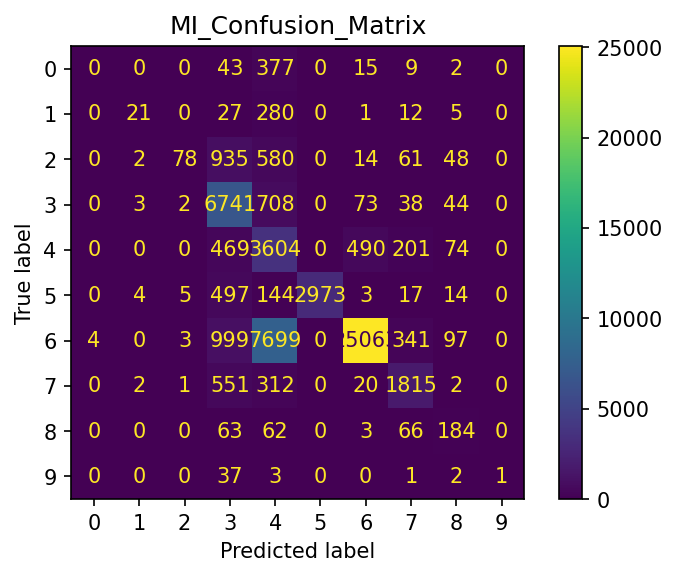

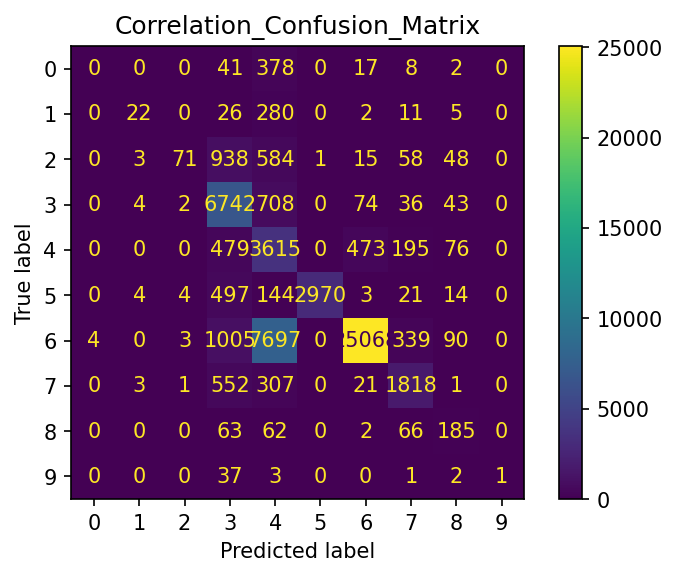

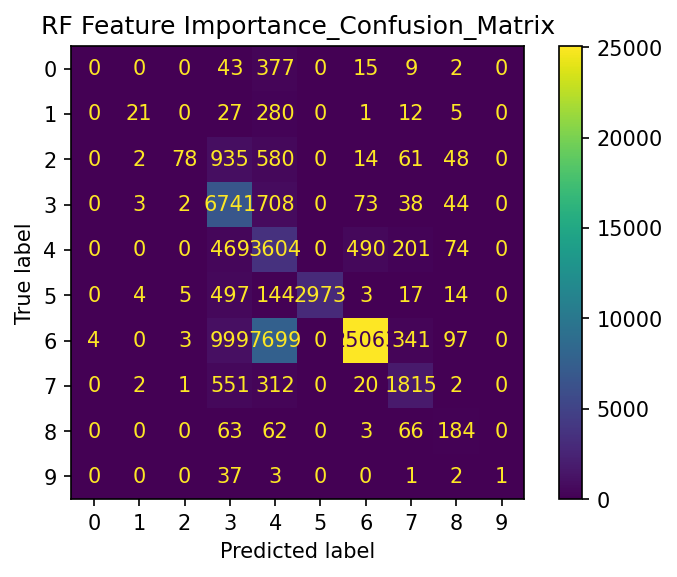

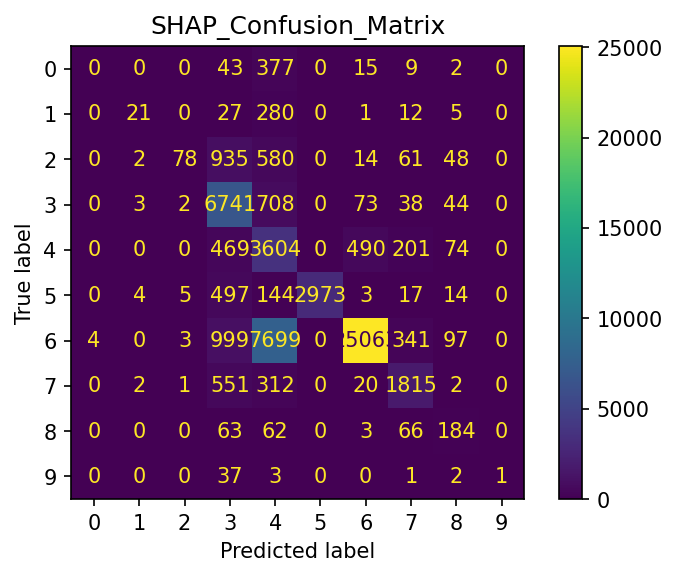

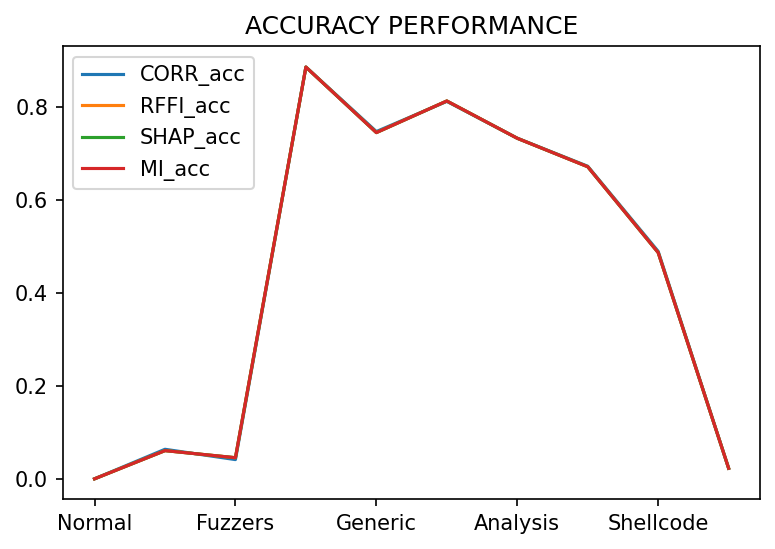

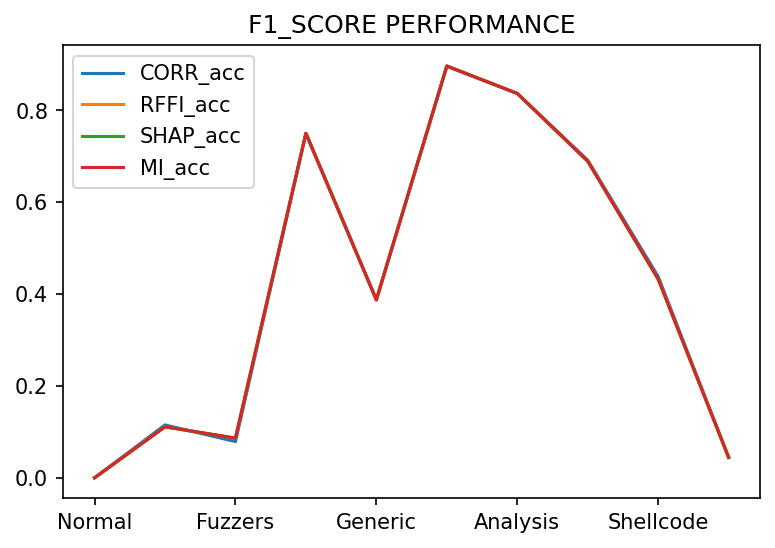

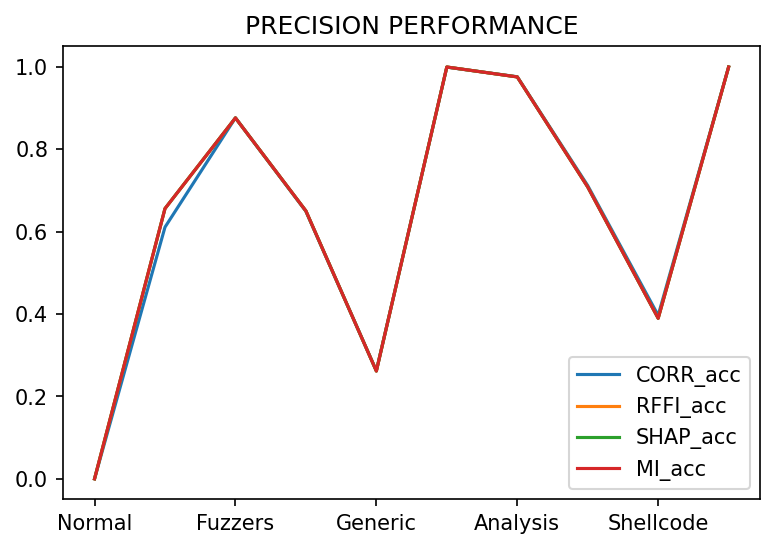

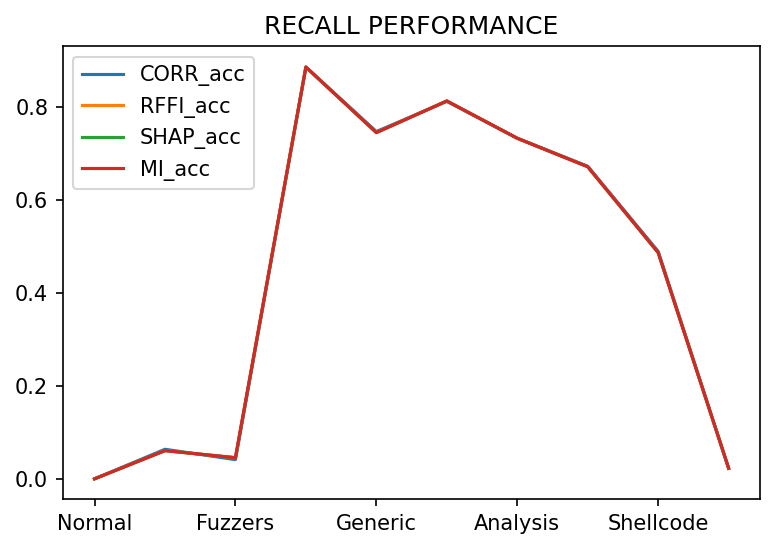

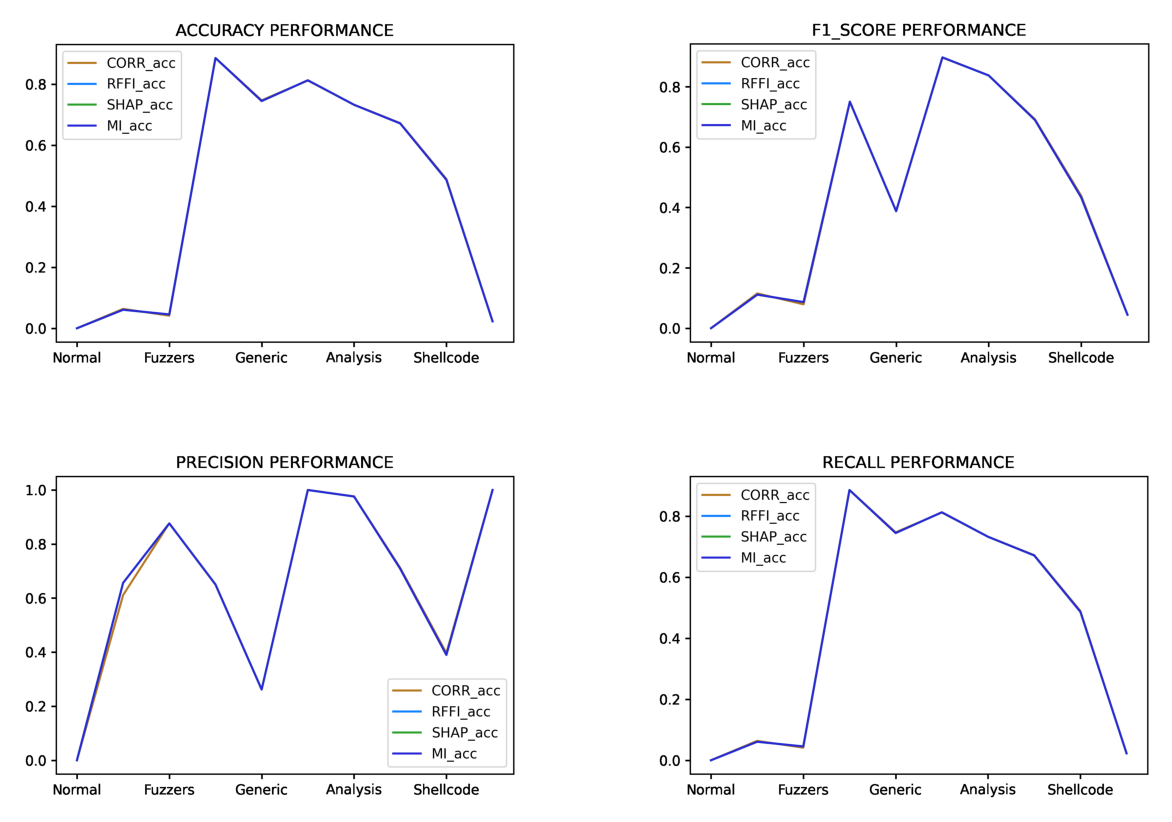

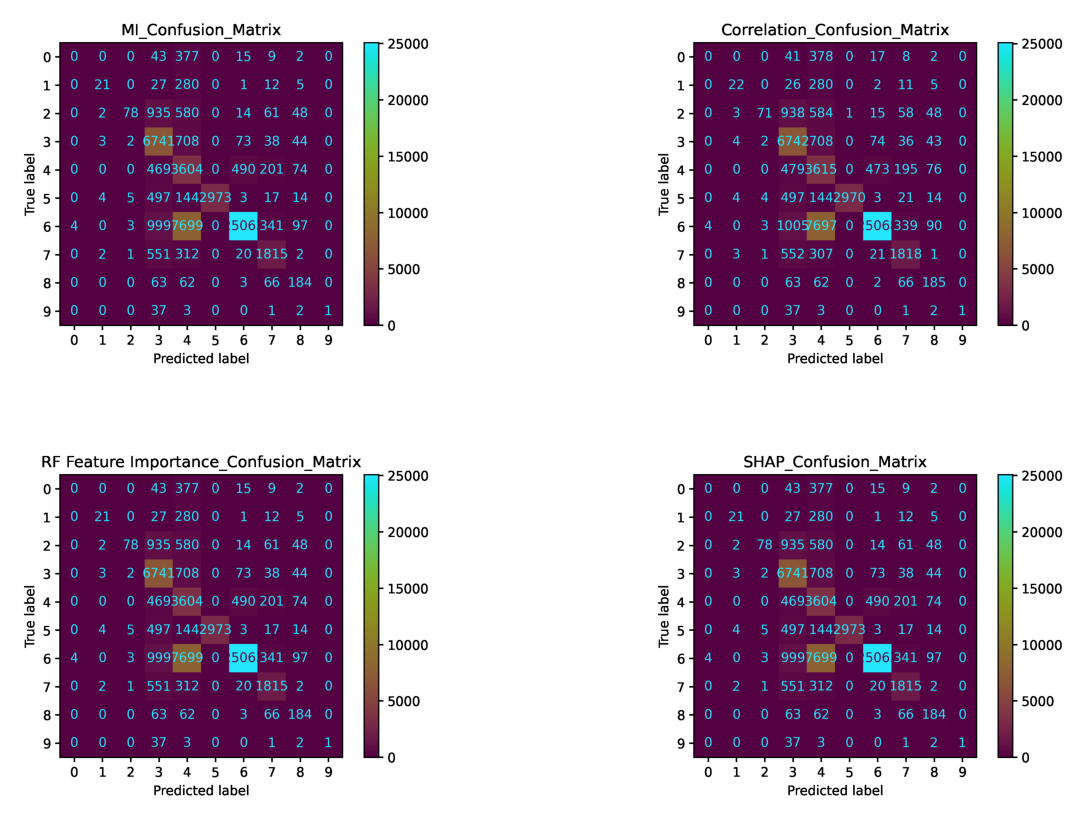

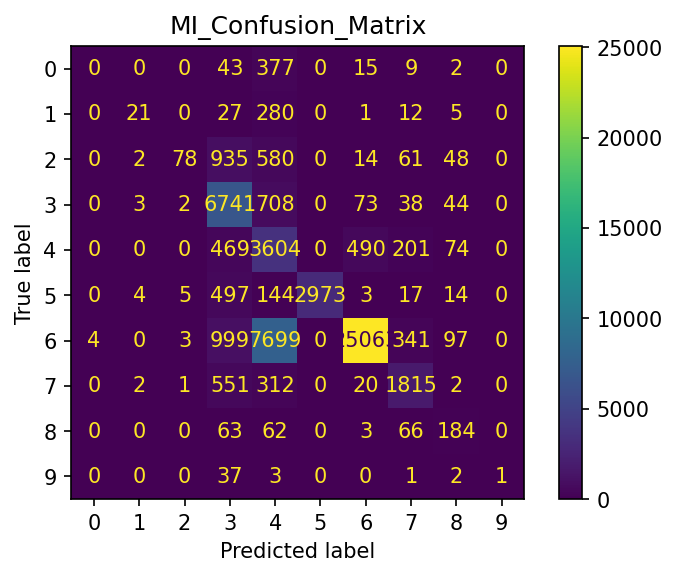

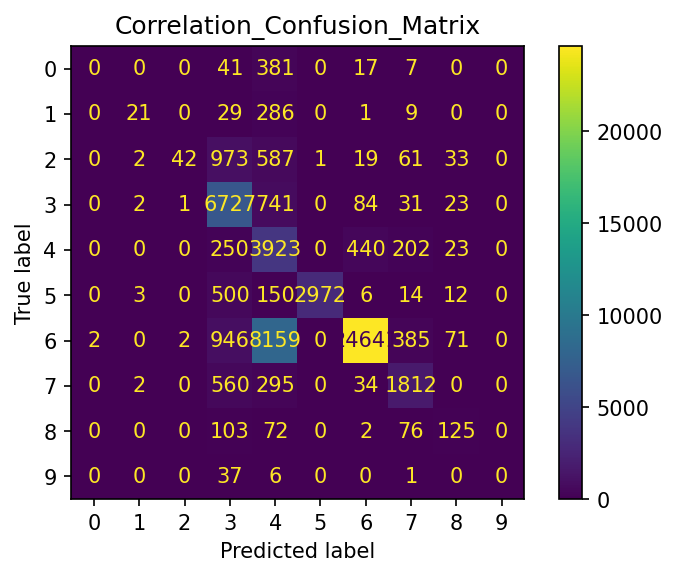

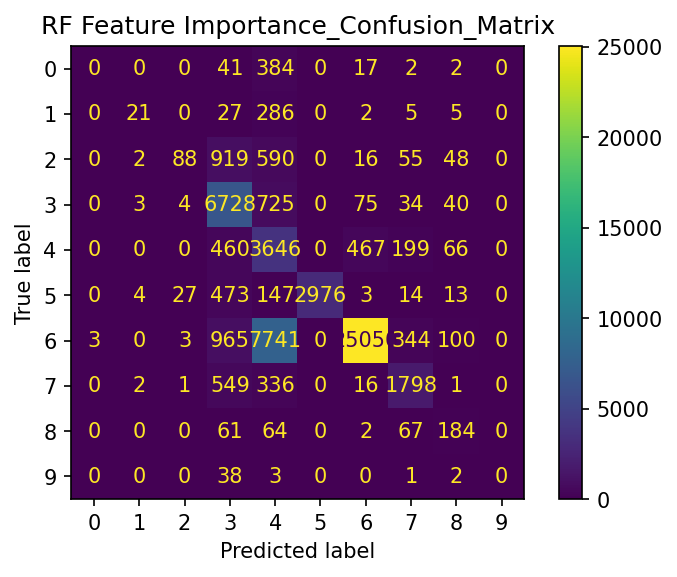

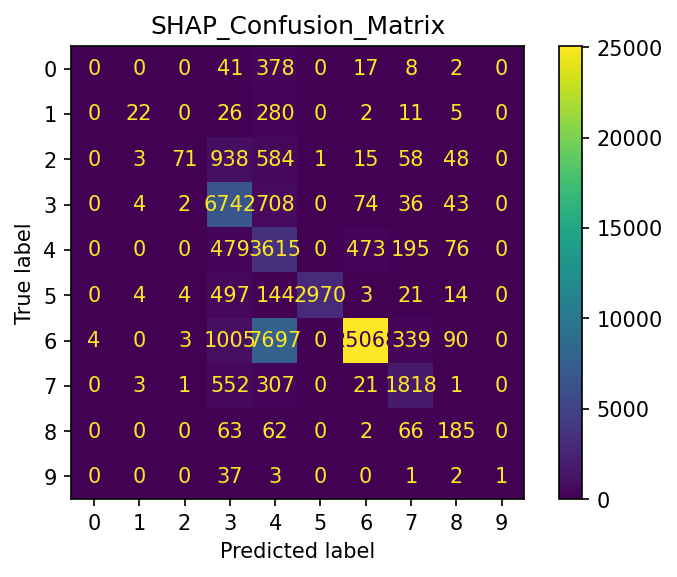

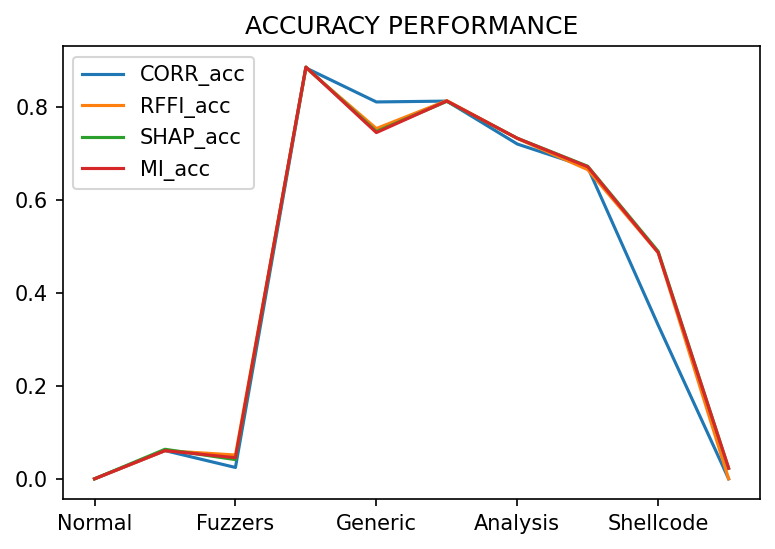

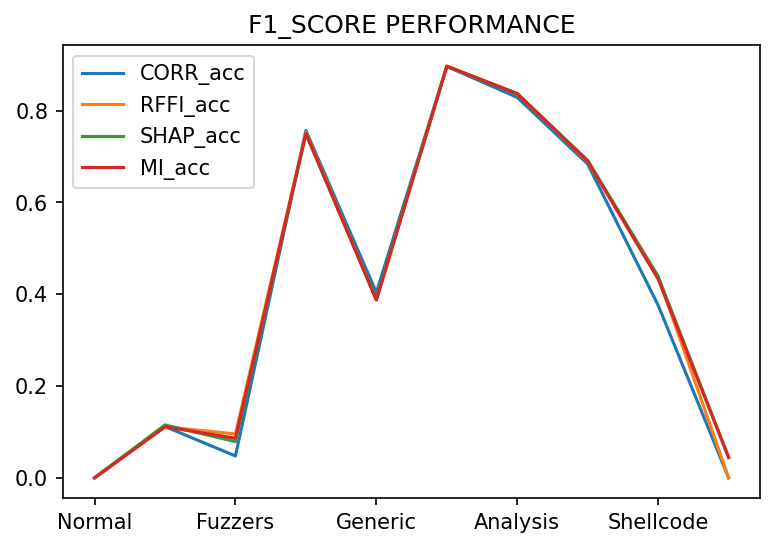

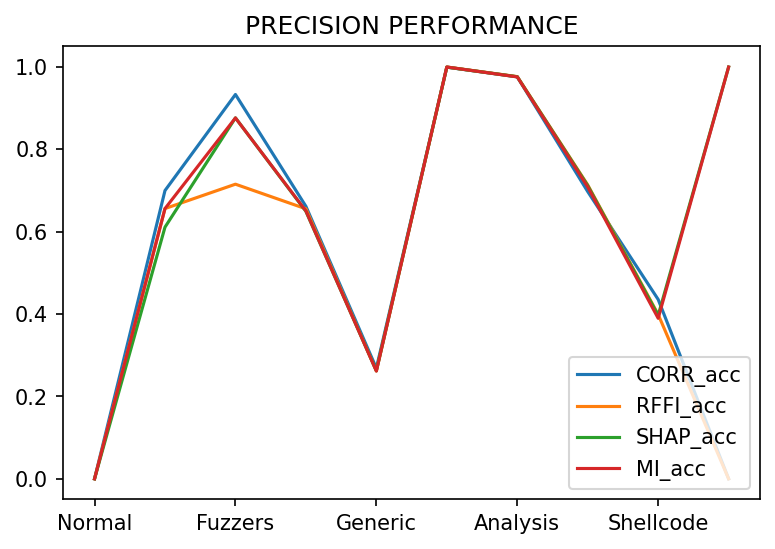

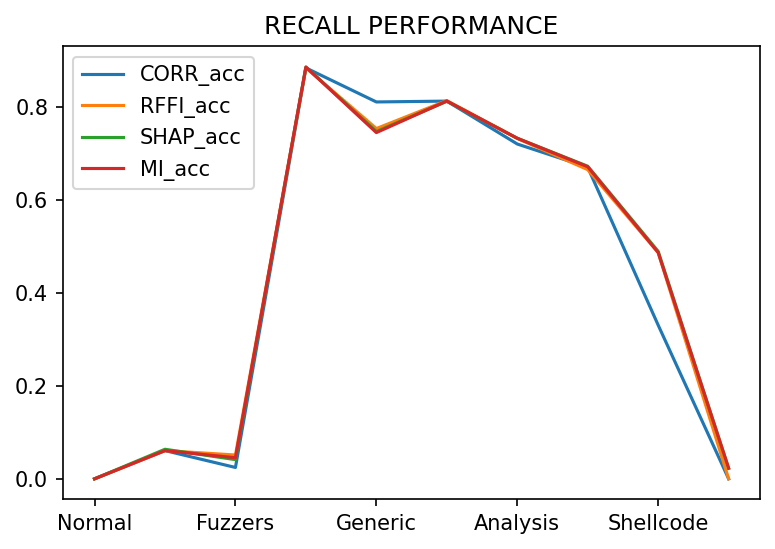

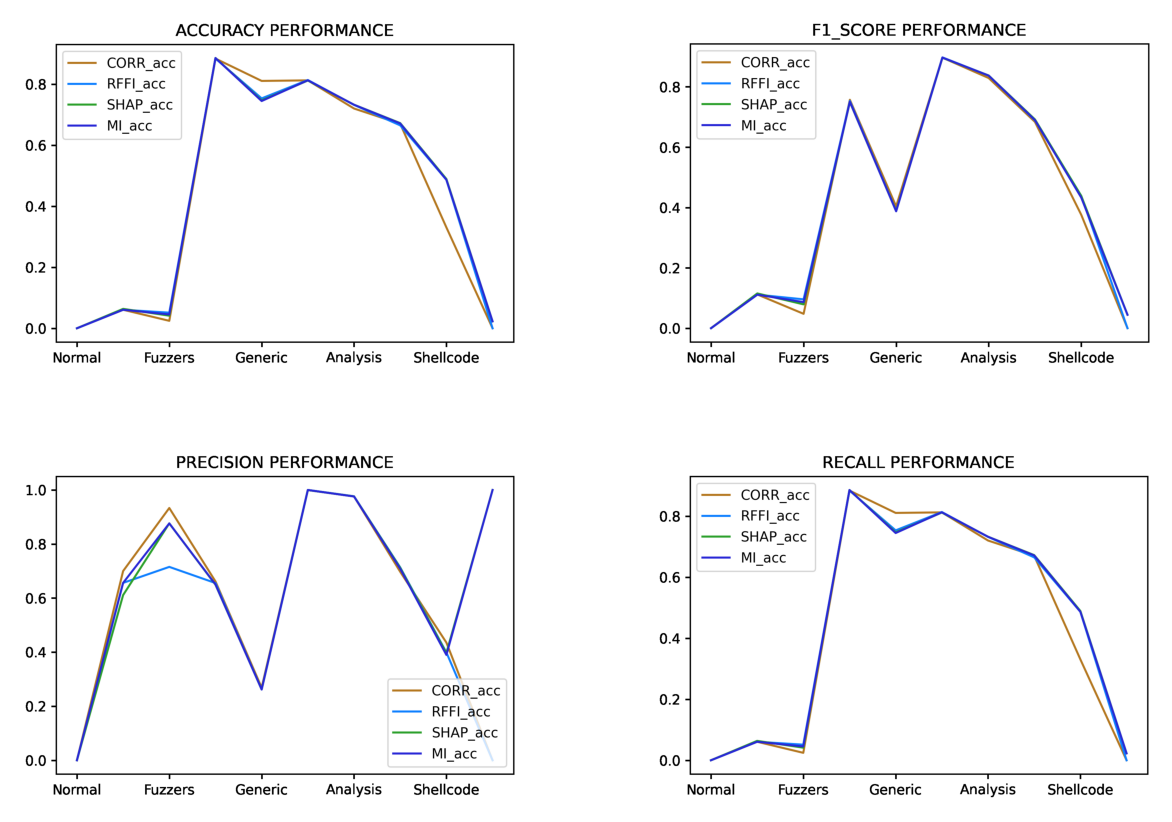

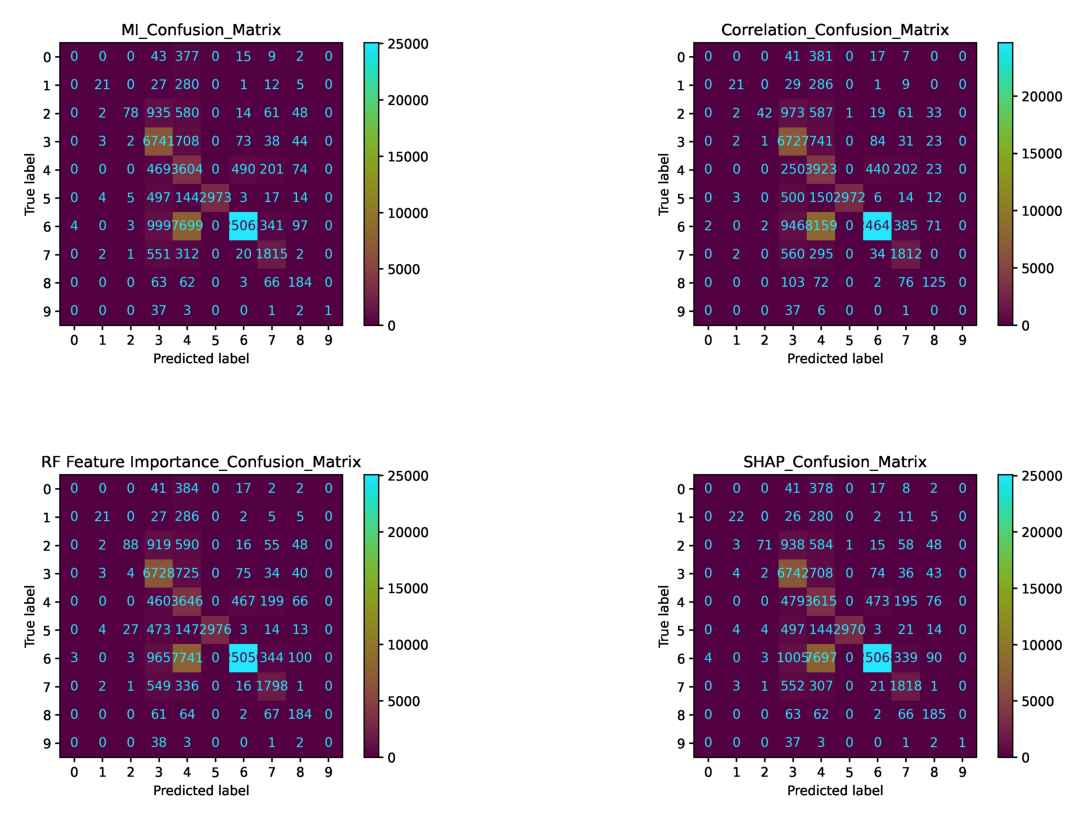

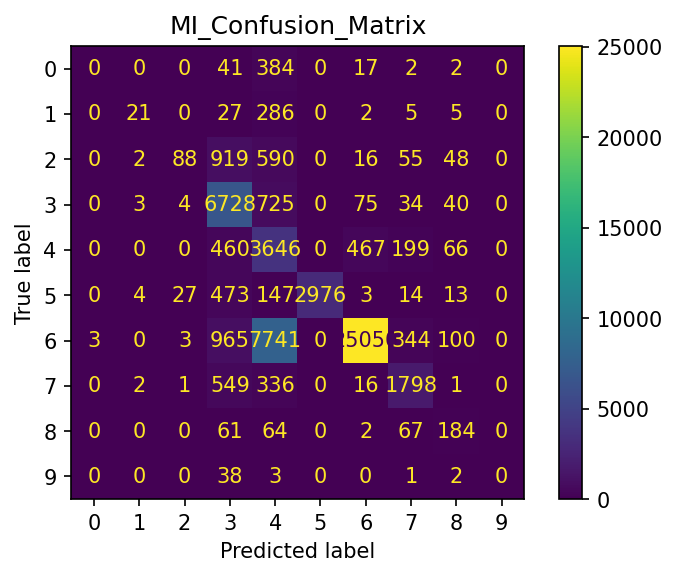

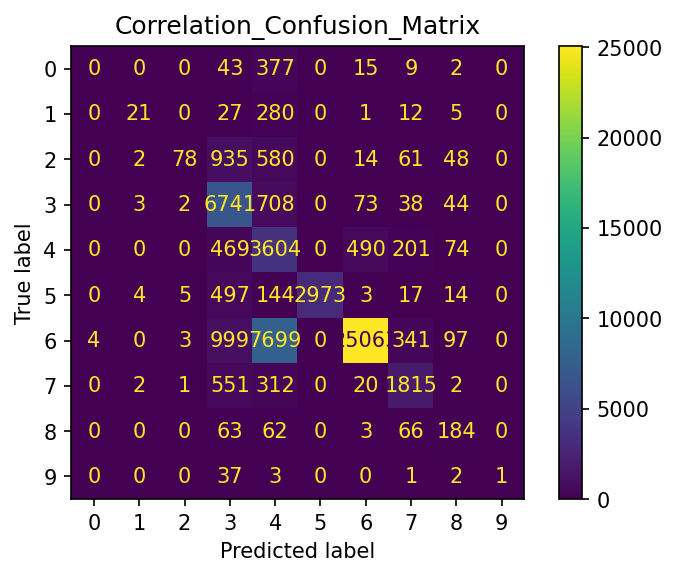

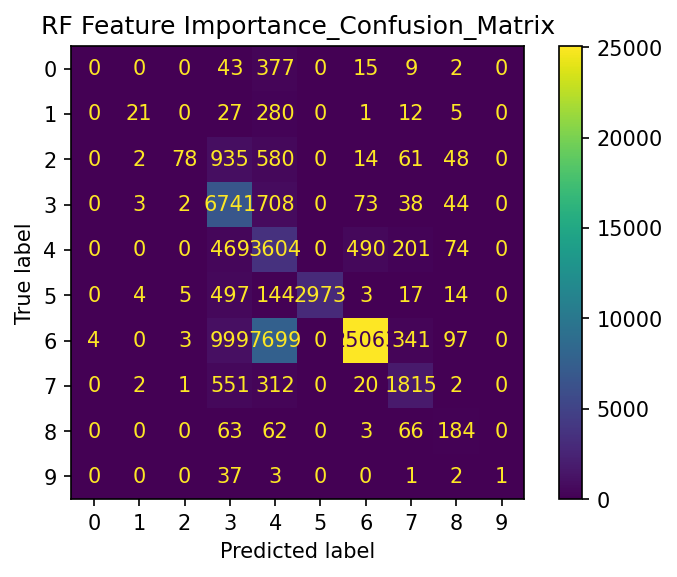

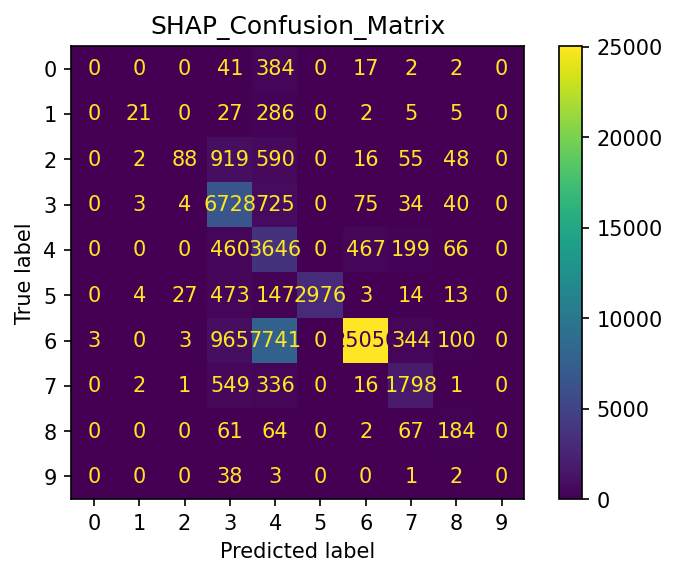

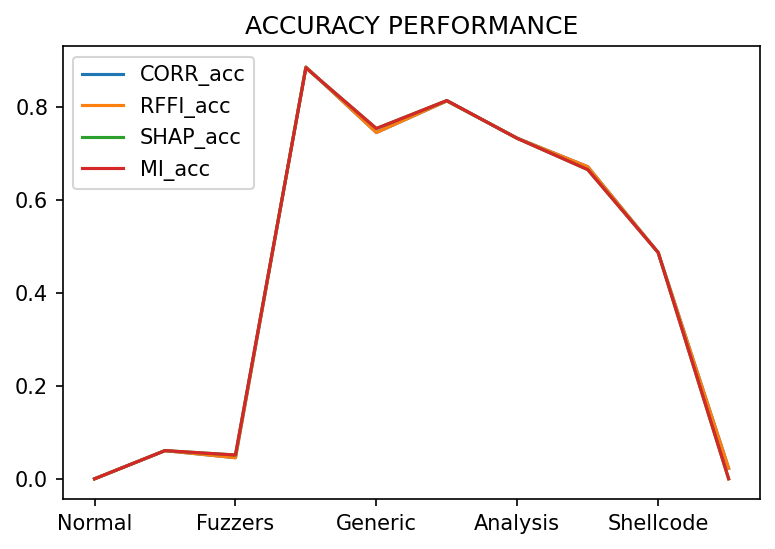

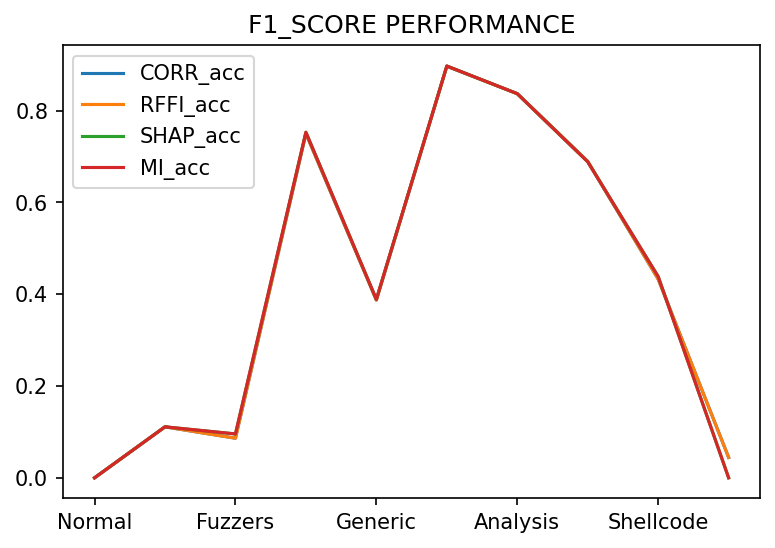

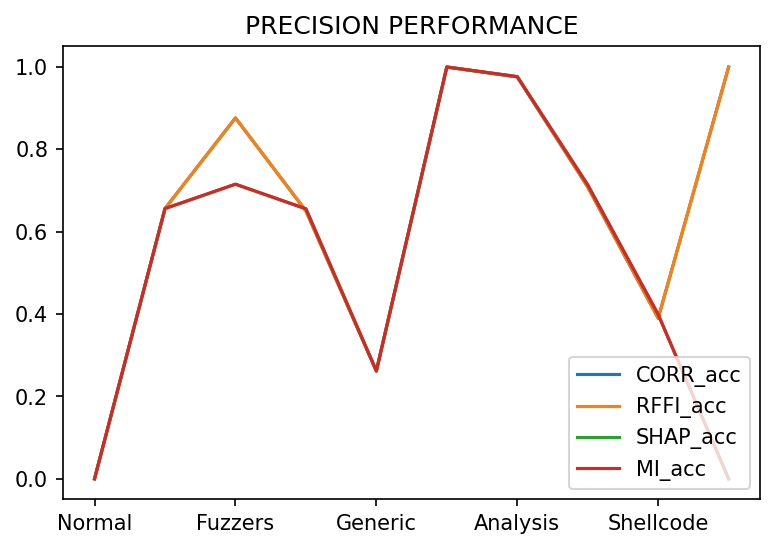

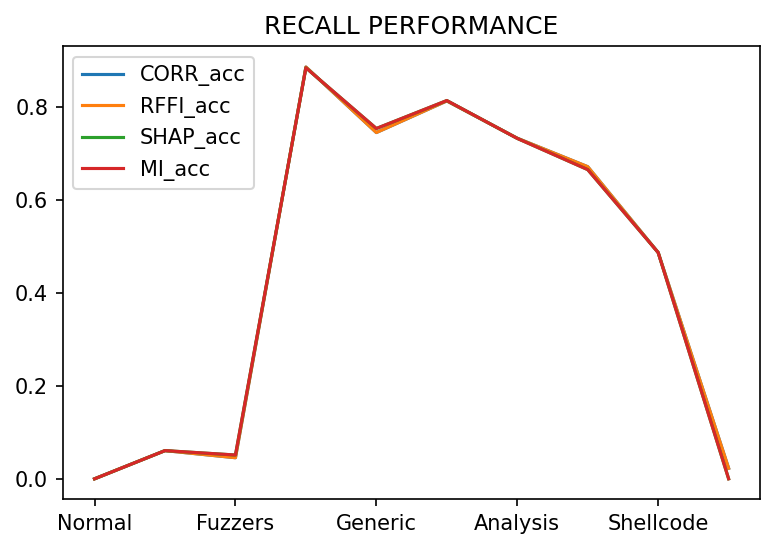

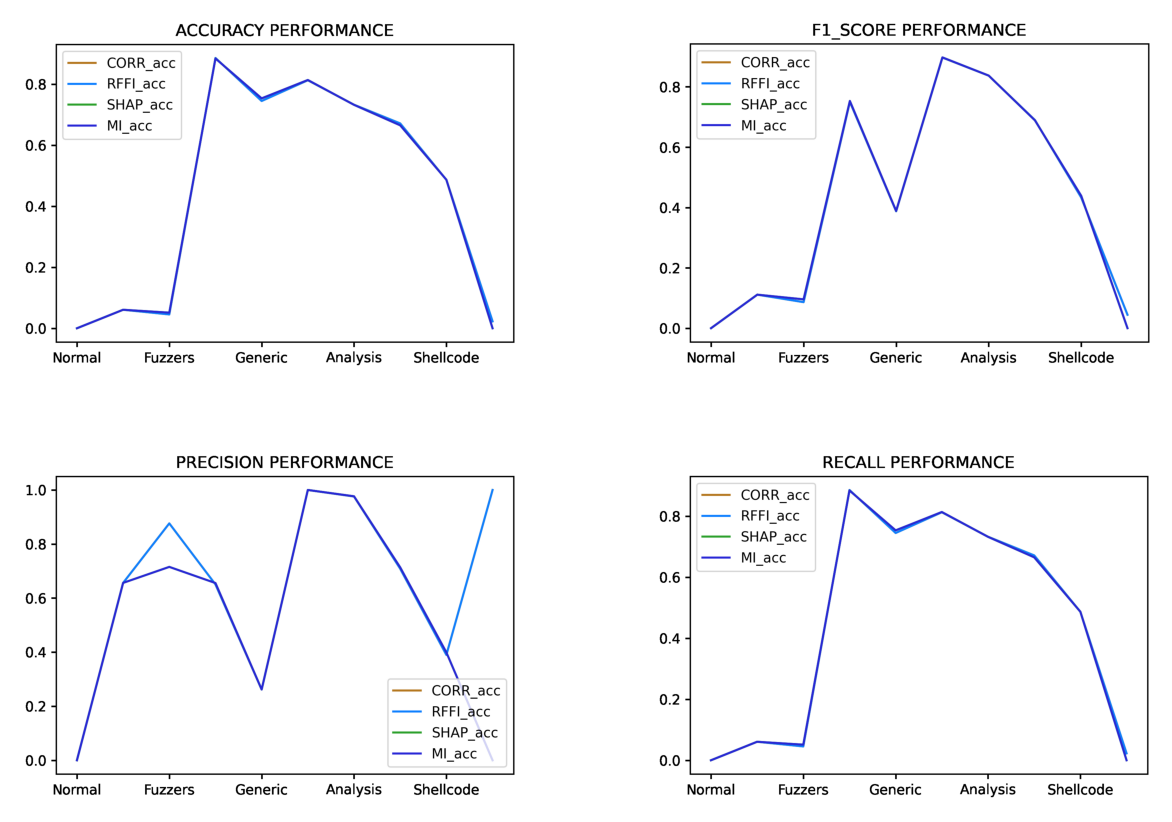

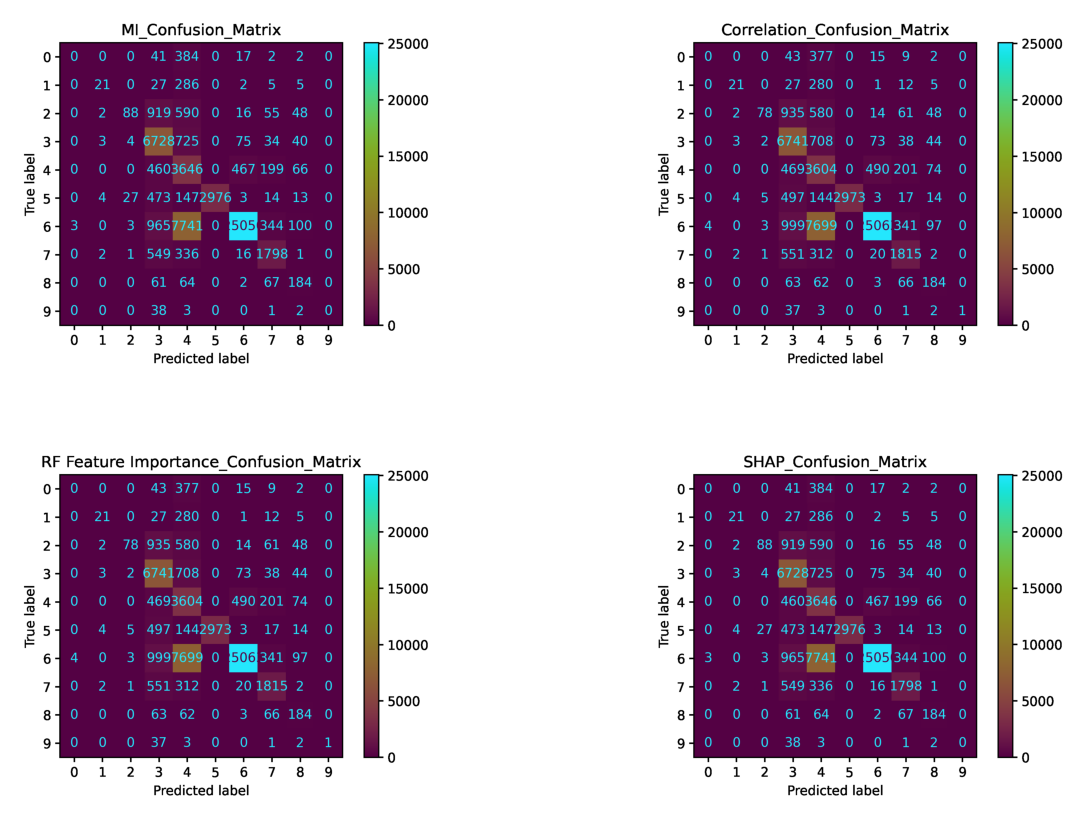

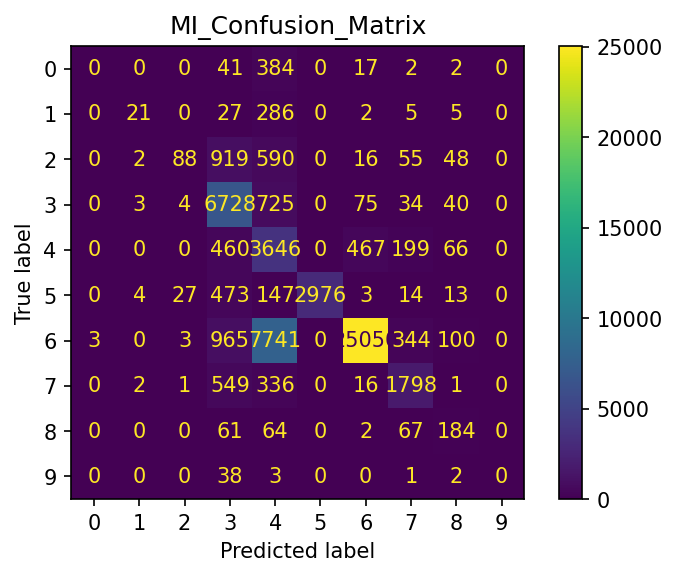

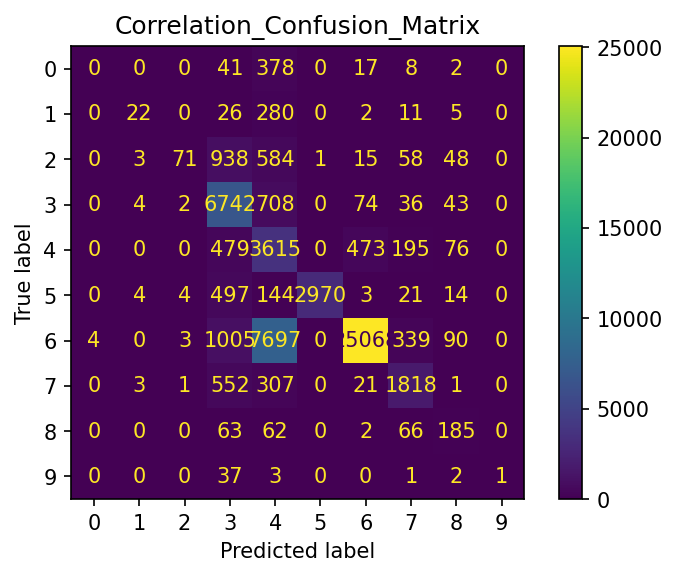

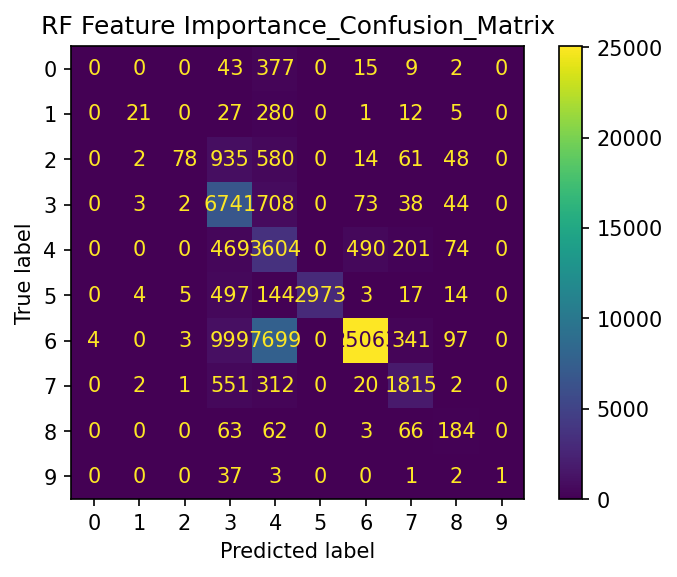

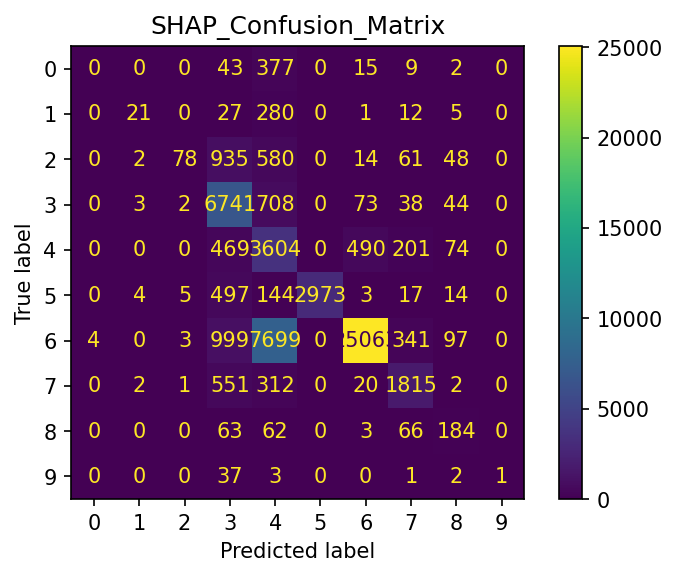

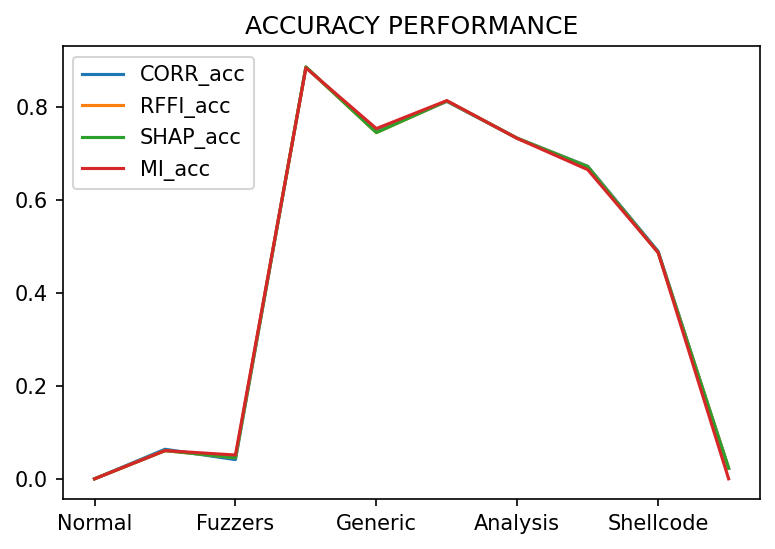

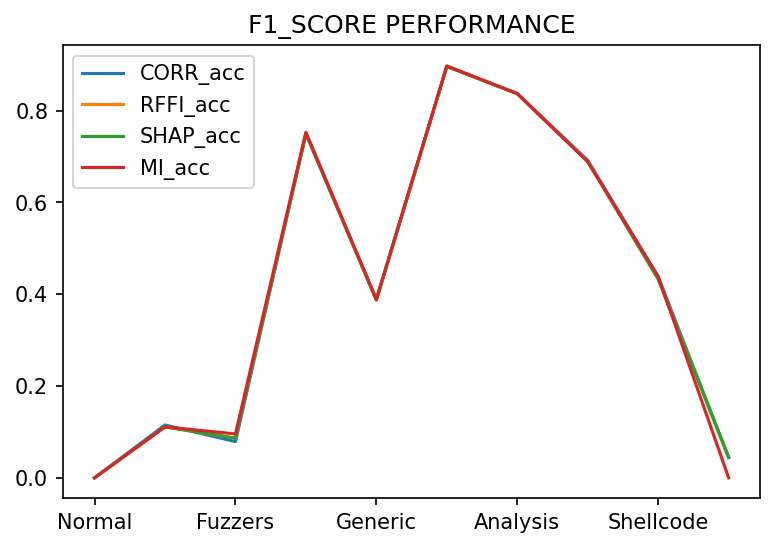

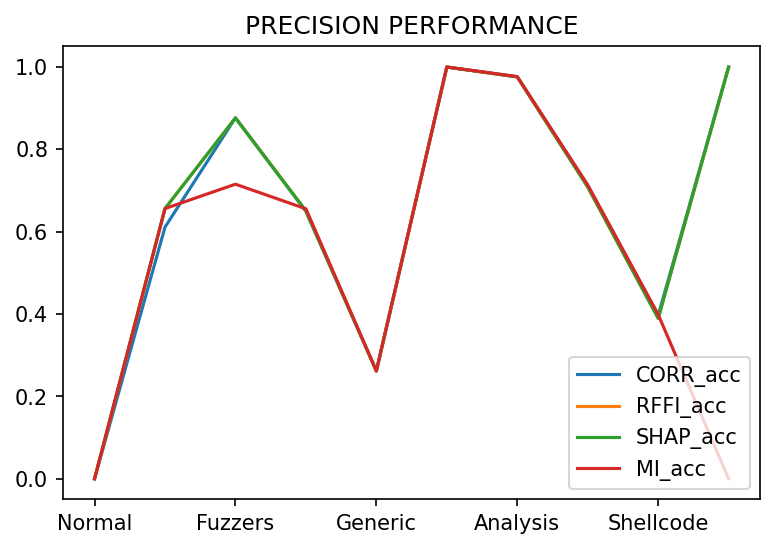

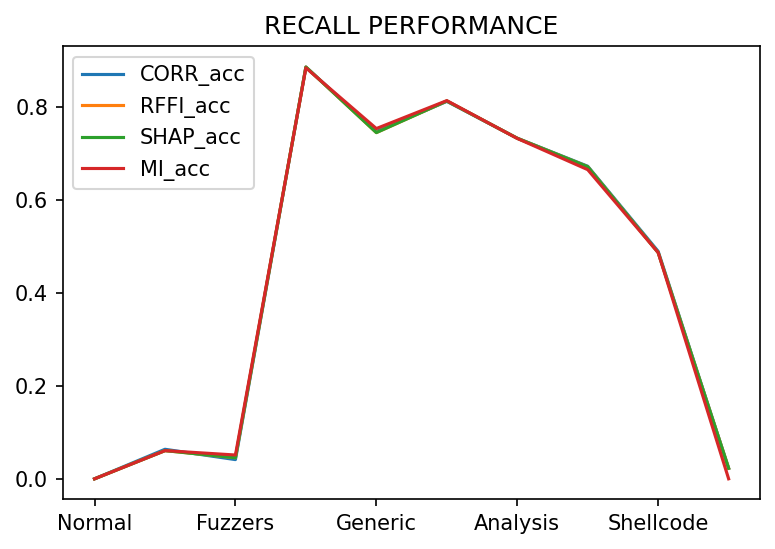

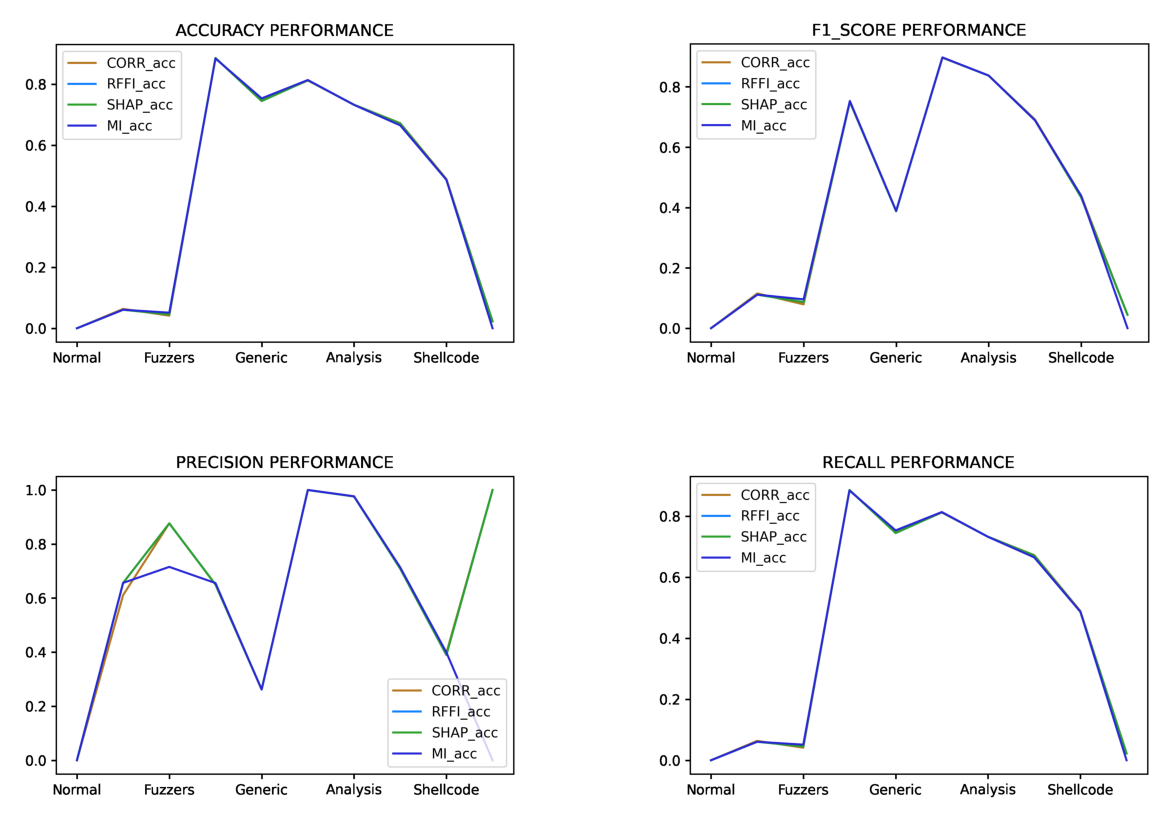

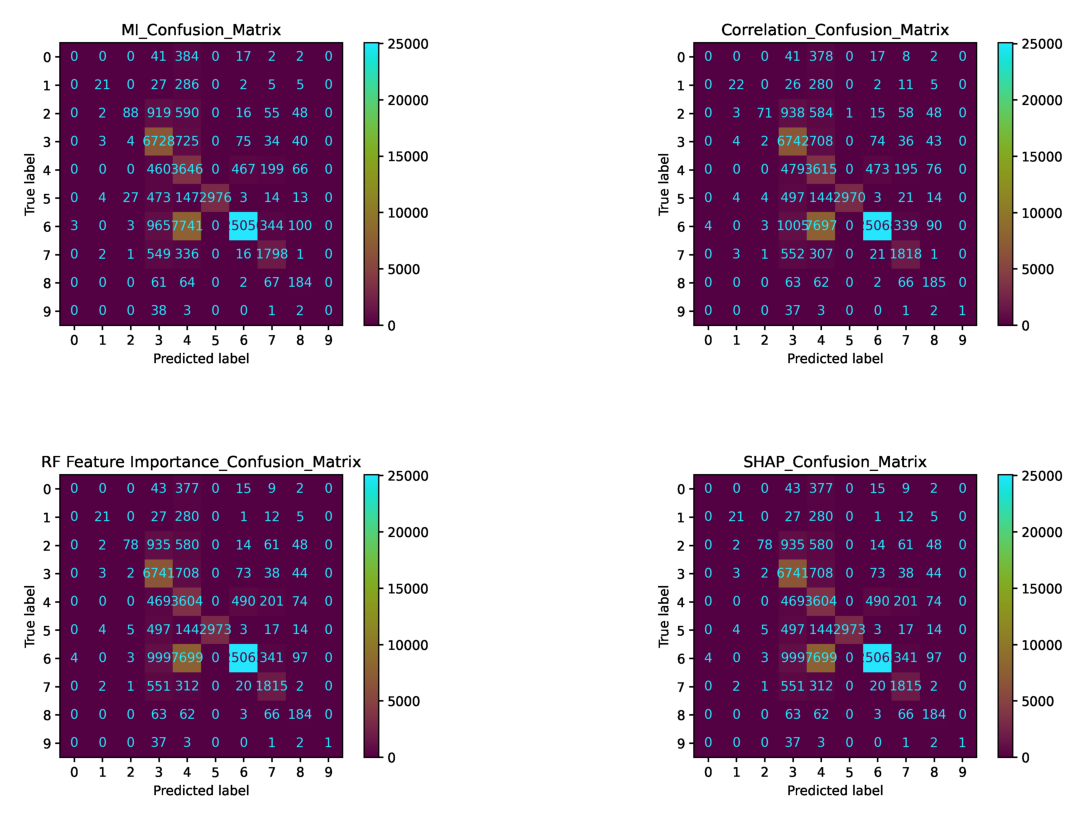

In [68]:
atype = 'MultiClass'
dataset = 'UNSW'

k_list = [32,28,21,11]

for k in tqdm(k_list):

    MI_features = MI_topk_features(scaled_enc_df_train, k)
    CORR_features = CORR_topk_features(scaled_enc_df_train, k)
    RFFI_features = RFFI_topk_features(scaled_enc_df_train, k)

    NumberOfInstances = 1
    SHAP_features = SHAP_topk_features(scaled_enc_df_train, scaled_enc_df_test, NumberOfInstances, k)

    MI_performance = model_performance(scaled_enc_df_train, scaled_enc_df_test, MI_features, 'MI', k, atype, dataset)
    CORR_performance = model_performance(scaled_enc_df_train, scaled_enc_df_test, CORR_features, 'Correlation', k, atype)
    RFFI_performance = model_performance(scaled_enc_df_train, scaled_enc_df_test, RFFI_features, 'RF Feature Importance', k, atype)
    SHAP_performance = model_performance(scaled_enc_df_train, scaled_enc_df_test, SHAP_features, 'SHAP', k, atype)

    metrics = ['Accuracy', 'F1_Score', 'Precision', 'Recall']

    for metric in metrics:
        #Multi_Class_Performance_BarChart(MI_performance, CORR_performance, RFFI_performance, SHAP_performance, metric,k,dataset)
        Multi_Class_Performance_LineChart(MI_performance, CORR_performance, RFFI_performance, SHAP_performance, metric,k,dataset)

    i1 = str(f'visualization/Figures/{dataset}_MultiClass_k{str(k)}_Accuracy_Line.png')
    i2 = str(f'visualization/Figures/{dataset}_MultiClass_k{str(k)}_F1_Score_Line.png')
    i3 = str(f'visualization/Figures/{dataset}_MultiClass_k{str(k)}_Precision_Line.png')
    i4 = str(f'visualization/Figures/{dataset}_MultiClass_k{str(k)}_Recall_Line.png')
    Multi_Class_Summary_Plots(i1,i2,i3,i4, 'Line_Chart',k,dataset)

    # i1 = str(f'visualization/Figures/{dataset}_MultiClass_k{str(k)}_Accuracy_Bar.png')
    # i2 = str(f'visualization/Figures/{dataset}_MultiClass_k{str(k)}_F1_Score_Bar.png')
    # i3 = str(f'visualization/Figures/{dataset}_MultiClass_k{str(k)}_Precision_Bar.png')
    # i4 = str(f'visualization/Figures/{dataset}_MultiClass_k{str(k)}_Recall_Bar.png')
    # Multi_Class_Summary_Plots(i1,i2,i3,i4, 'Bar_Chart',k,dataset)

    i1 = str(f'visualization/Figures/{dataset}_MultiClass_k{str(k)}_MI_Confusion_Matrix.png')
    i2 = str(f'visualization/Figures/{dataset}_MultiClass_k{str(k)}_Correlation_Confusion_Matrix.png')
    i3 = str(f'visualization/Figures/{dataset}_MultiClass_k{str(k)}_RF Feature Importance_Confusion_Matrix.png')
    i4 = str(f'visualization/Figures/{dataset}_MultiClass_k{str(k)}_SHAP_Confusion_Matrix.png')
    Multi_Class_Summary_Plots(i1,i2,i3,i4, 'Confusion_Matrix',k,dataset)


```
Binary Analysis
```

In [52]:
df_train = pd.read_csv('../Data/UNSW_NB15_training-set.csv')
df_test = pd.read_csv('../Data/UNSW_NB15_testing-set.csv')

In [53]:
df_train = df_train.drop(['id', 'attack_cat'], axis=1)
df_test = df_test.drop(['id', 'attack_cat'], axis=1)

df_train = df_train.drop_duplicates(keep='first').reset_index(drop=True)
df_test = df_test.drop_duplicates(keep='first').reset_index(drop=True)

global categorical_features_train, categorical_features_test
categorical_features_train = list(df_train.select_dtypes(include=['object']).columns)
categorical_features_test = list(df_test.select_dtypes(include=['object']).columns)

global numerical_features_train, numerical_features_test
numerical_features_train = list(df_train.select_dtypes(exclude=['object']).columns)
numerical_features_test = list(df_test.select_dtypes(exclude=['object']).columns)

In [54]:
df_train.columns

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'label'],
      dtype='object')

In [55]:
lab_enc_df_train = df_train.copy()
lab_enc_df_test = df_test.copy()

labelencoder = LabelEncoder()

for c in categorical_features_train:
    lab_enc_df_train[c] = labelencoder.fit_transform(lab_enc_df_train[c])

for c in categorical_features_test:
    lab_enc_df_test[c] = labelencoder.fit_transform(lab_enc_df_test[c])

scaled_enc_df_train = lab_enc_df_train.copy()
scaled_enc_df_test = lab_enc_df_test.copy()

col_names = numerical_features_train
features = scaled_enc_df_train[col_names]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_enc_df_train[col_names] = features

col_names = numerical_features_test
features = scaled_enc_df_test[col_names]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_enc_df_test[col_names] = features

In [56]:
def MI_topk_features(df_pp, k):

    now = datetime.now()
    print(f'{now} - Mutual Information feature selection Initialized..')

    X = df_pp.iloc[:,:-1]
    y = df_pp.iloc[:,-1]

    importances = mutual_info_classif(X,y)
    feature_imp = pd.Series(importances, df_pp.columns[0:len(df_pp.columns)-1])

    MI_features = list(feature_imp.sort_values(ascending = False)[:k].index)

    now = datetime.now()
    print(f'{now} - Mutual Information feature selection Successful!')

    return MI_features

def CORR_topk_features(df_pp, k):

    now = datetime.now()
    print(f'{now} - Correlation feature selection Initialized..')

    cor = df_pp.corr()
    CORR_features = list(abs(cor['label']).sort_values(ascending=False)[:k+1].index)
    CORR_features.remove('label')

    now = datetime.now()
    print(f'{now} - Correlation feature selection Successful!')

    return CORR_features

def RFFI_topk_features(df_pp, k):
    
    now = datetime.now()
    print(f'{now} - RF Feature Importance feature selection Initialized..')

    X = df_pp.iloc[:,:-1]
    y = df_pp.iloc[:,-1]

    rf = RandomForestClassifier(n_estimators=200,random_state=42)
    rf.fit(X.values,y.values)
    rffi = rf.feature_importances_

    features = pd.Series(rffi, df_pp.columns[0:len(df_pp.columns)-1])
    RFFI_features = list(features.sort_values(ascending = False)[:k].index)

    now = datetime.now()
    print(f'{now} - RF Feature Importance feature selection Successful!')

    return RFFI_features

def SHAP_topk_features(df_train, df_test, number_of_instances, k):

    now = datetime.now()
    print(f'{now} - SHAP feature selection Initialized!')

    train_X =  df_train.iloc[:,:-1]
    test_X = df_test.iloc[:,:-1]
    train_y = df_train.iloc[:,-1]
    test_y = df_test.iloc[:,-1]

    rf = RandomForestClassifier(random_state=42).fit(train_X.values,train_y.values)
    shap_df = pd.DataFrame()

    for target in list(train_y.value_counts().index):   
        target = int(target)
        i = []
        v = []

        for index, value in zip(range(len(train_y)), train_y):    
            i.append(index)
            v.append(value)
        
        y_val = pd.Series(v,i)
        y_val = list(y_val[y_val==target].index)

        idx_threshold = number_of_instances
        final_idx = []

        for idx in y_val:
            if idx_threshold > 0:
                row_instance = train_X.iloc[idx]
                row_pred = row_instance.values.reshape(1, -1)

                if float(rf.predict_proba(row_pred)[0][target]) == 1.0:
                    final_idx.append(idx)
                    idx_threshold = idx_threshold - 1
            else:
                break

        temp_df = pd.DataFrame()

        for idx in final_idx:
            row_instance = train_X.iloc[idx]
            row_pred = row_instance.values.reshape(1, -1)
            
            explainer = shap.TreeExplainer(rf)
            shap_values = explainer.shap_values(row_instance)

            series_idx = row_instance.index
            series_val = shap_values[target]

            feature_series = pd.Series(series_val, series_idx)
            
            shap_df_temp = feature_series.to_frame().rename(columns={0:'shap_value'}).rename_axis('features').reset_index()
            temp_df = temp_df.append(shap_df_temp, ignore_index = True)

        temp_df = temp_df.sort_values(by=['shap_value'], ascending=False).drop_duplicates(subset='features', keep='first')
        shap_df = shap_df.append(temp_df, ignore_index = True)    

    shap_df = shap_df.sort_values(by=['shap_value'], ascending=False).drop_duplicates(subset='features', keep='first')
    shap_features = list(shap_df['features'].iloc[:k])

    now = datetime.now()
    print(f'{now} - SHAP feature selection Successful!')

    return shap_features

In [57]:
def model_performance(df_train, df_test, features, technique, k, atype='', dataset='UNSW'):

    now = datetime.now()
    print(f'{now} - Model training started!')

    train_X =  df_train[features]
    test_X = df_test[features]
    train_y = df_train.iloc[:,-1]
    test_y = df_test.iloc[:,-1]

    scorer = {
            'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score, average = 'macro', zero_division = 1),
            'recall': make_scorer(recall_score, average = 'weighted'),
            'f1': make_scorer(f1_score, average = 'weighted')
                }

    param_grid = { 
            'n_estimators': [200, 300, 400],
            'max_depth' : [6,7,8,9,10],
            'criterion' : ['entropy']
    }

    clf = RandomForestClassifier(random_state = 42)

    g_search = RandomizedSearchCV(estimator = clf, 
                            param_distributions = param_grid, 
                            cv = 3, 
                            n_jobs = -1, 
                            scoring=scorer,
                            refit='f1')

    g_search.fit(train_X, train_y)

    n_estimators = g_search.best_params_['n_estimators']
    max_depth = g_search.best_params_['max_depth']
    criterion = g_search.best_params_['criterion']


    clf=RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion, random_state=42)
    clf.fit(train_X.values,train_y.values)
    y_pred=clf.predict(test_X)

    plot_confusion_matrix(clf, test_X, test_y)
    plt.title(f"{technique}_Confusion_Matrix")
    plt.show()
    plt.savefig(f"visualization/Figures/{dataset}_{atype}_k{str(k)}_{str(technique)}_Confusion_Matrix.png", dpi=300, bbox_inches='tight')
    
    sk_report = classification_report(
    digits=6,
    y_true=test_y, 
    y_pred=y_pred,
    output_dict=True)

    report_df = pd.DataFrame(sk_report).transpose()
    
    filename = "visualization/Figures/"+dataset+'_'+atype+"_k"+str(k)+'_'+str(technique)+"_Performance_Report" + ".png"
    dfi.export(report_df,filename)

    performance_dictionary={'Technique':[], 'Class':[],'Accuracy':[],'F1_Score':[],'Precision':[],'Recall':[], 'HP_n_estimators':[], 'HP_max_depth':[], 'k':[]}

    f1 = list(f1_score(test_y, y_pred, average=None))
    matrix = confusion_matrix(test_y, y_pred)
    acc = list(matrix.diagonal()/matrix.sum(axis=1))
    pr = list(precision_score(test_y, y_pred, average=None))
    rl = list(recall_score(test_y, y_pred, average=None))

    for i in range(len(f1)):
        performance_dictionary['Technique'].append(technique)
        performance_dictionary['Class'].append(i)
        performance_dictionary['Accuracy'].append(acc[i])
        performance_dictionary['F1_Score'].append(f1[i])
        performance_dictionary['Precision'].append(pr[i])
        performance_dictionary['Recall'].append(rl[i])
        performance_dictionary['HP_n_estimators'].append(n_estimators)
        performance_dictionary['HP_max_depth'].append(max_depth)
        performance_dictionary['k'].append(k)
        

    df = pd.DataFrame.from_dict(performance_dictionary)

    now = datetime.now()
    print(f'{now} - Model performance dataframe created Successfully!')

    return df

In [58]:
def Binary_Performance_BarChart(MI_perf_df, CORR_perf_df, RFFI_perf_df, SHAP_perf_df, metric,k,dataset='KDDCUP'):

    now = datetime.now()
    print(f'{now} - Initializing {str.upper(metric)} Binary comparision Bar Chart visualization..')

    plt.rcParams['figure.dpi'] = 150
    X = ['Normal','Anomaly']
    
    MI_acc = list(MI_perf_df[metric])
    CORR_acc = list(CORR_perf_df[metric])
    RFFI_acc = list(RFFI_perf_df[metric])
    SHAP_acc = list(SHAP_perf_df[metric])

    df = pd.DataFrame({'MI_acc': MI_acc,
                   'CORR_acc': CORR_acc,
                   'RFFI_acc': RFFI_acc,
                   'SHAP_acc': SHAP_acc
                   }, index=X)
    ax = df.plot.bar(rot=0)

    plt.title(str.upper(metric) + ' PERFORMANCE')
    plt.legend()
    plt.savefig(f"visualization/Figures/{dataset}_Binary_k{str(k)}_{metric}_Bar.png", dpi=300, bbox_inches='tight')

    now = datetime.now()
    print(f'{now} - {str.upper(metric)} BinaryClass comparision bar chart visualization generated Successfully!')

def Binary_Performance_ScatterChart(MI_perf_df, CORR_perf_df, RFFI_perf_df, SHAP_perf_df, metric,k,dataset):

    now = datetime.now()
    print(f'{now} - Initializing {str.upper(metric)} BinaryClass comparision Scatter Chart visualization..')

    plt.rcParams['figure.dpi'] = 150
    
    X = ['Normal','Anomaly']
    
    SHAP = list(SHAP_perf_df[metric])
    MI = list(MI_perf_df[metric])
    CORR = list(CORR_perf_df[metric])
    RFFI = list(RFFI_perf_df[metric])
    
    df = pd.DataFrame({'CORR': CORR,
                   'RFFI': RFFI,
                   'SHAP': SHAP, 
                   'MI': MI,
                   'Class' : X
                   })
    c=['r','g','orange', 'purple']
    Y= ['CORR','RFFI','SHAP','MI']
    fig, ax = plt.subplots()

    for m in range(len(Y)):
        ax.scatter(x=df['Class'], y=df[Y[m]], color=c[m],label=df[Y[m]].name)    

    plt.xlabel('Class')
    plt.ylabel(metric)
    plt.title(str.upper(metric) + ' PERFORMANCE')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"visualization/Figures/{dataset}_Binary_k{str(k)}_{metric}_Scatter.png", dpi=300, bbox_inches='tight')


    now = datetime.now()
    print(f'{now} - {str.upper(metric)} BinaryClass comparision line chart visualization generated Successfully!')

def Binary_Summary_Plots(image1,image2, image3, image4, title_text,k,dataset):
    
    now = datetime.now()
    print(f'{now} - Initializing {title_text} BinaryClass summary plot..')

    plt.rcParams['figure.dpi'] = 150
    fig = plt.figure(figsize=(10, 7))
    rows = 2
    columns = 2
    
    Image1 = cv2.imread(image1)
    Image2 = cv2.imread(image2)
    Image3 = cv2.imread(image3)
    Image4 = cv2.imread(image4)
    
    fig.add_subplot(rows, columns, 1)
    
    plt.imshow(Image1)
    plt.axis('off')
        
    fig.add_subplot(rows, columns, 2)
    
    plt.imshow(Image2)
    plt.axis('off')
        
    fig.add_subplot(rows, columns, 3)
    
    plt.imshow(Image3)
    plt.axis('off')
        
    fig.add_subplot(rows, columns, 4)
    
    plt.imshow(Image4)
    plt.axis('off')
    
    plt.savefig(f"visualization/Figures_Summary/{dataset}_Binary_k{str(k)}_{title_text}_Summary_Plot.png", dpi=300, bbox_inches='tight')

    now = datetime.now()
    print(f'{now} - {title_text} BinaryClass summary plot completed!')

  0%|          | 0/4 [00:00<?, ?it/s]

Starting the Length of Features - 32
2022-02-07 21:18:49.513703 - Mutual Information feature selection Initialized..
2022-02-07 21:19:17.823269 - Mutual Information feature selection Successful!
2022-02-07 21:19:17.823269 - Correlation feature selection Initialized..
2022-02-07 21:19:18.354395 - Correlation feature selection Successful!
2022-02-07 21:19:18.354395 - RF Feature Importance feature selection Initialized..
2022-02-07 21:19:57.423317 - RF Feature Importance feature selection Successful!
2022-02-07 21:19:57.454528 - SHAP feature selection Initialized!
2022-02-07 21:20:23.995191 - SHAP feature selection Successful!
2022-02-07 21:20:24.028552 - Model training started!


X has feature names, but RandomForestClassifier was fitted without feature names
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but RandomForestClassifier was fitted without feature names


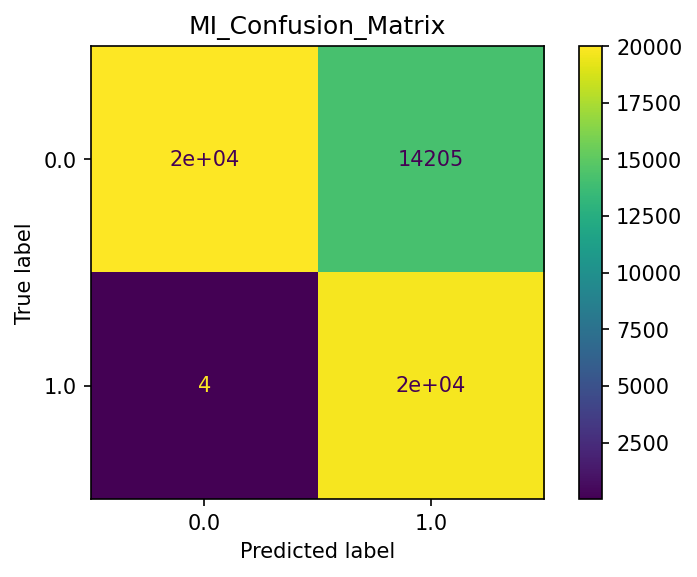

2022-02-07 21:26:23.047931 - Model performance dataframe created Successfully!
2022-02-07 21:26:23.047931 - Model training started!


X has feature names, but RandomForestClassifier was fitted without feature names
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but RandomForestClassifier was fitted without feature names


<Figure size 900x600 with 0 Axes>

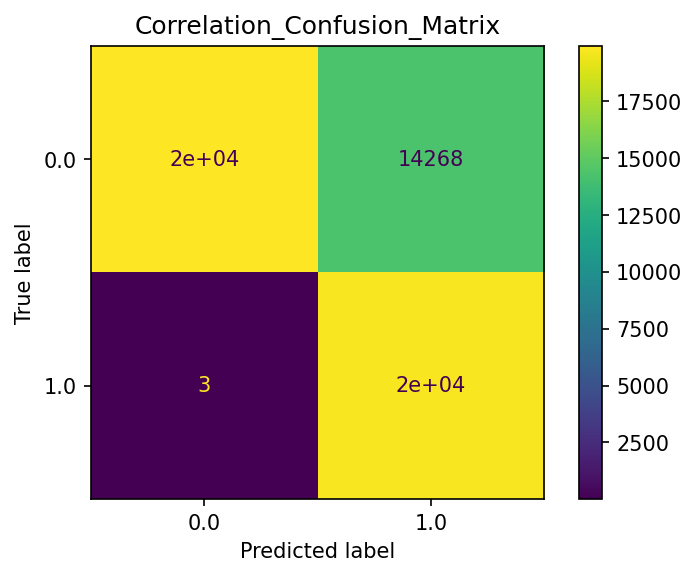

2022-02-07 21:31:27.033463 - Model performance dataframe created Successfully!
2022-02-07 21:31:27.038449 - Model training started!


X has feature names, but RandomForestClassifier was fitted without feature names
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but RandomForestClassifier was fitted without feature names


<Figure size 900x600 with 0 Axes>

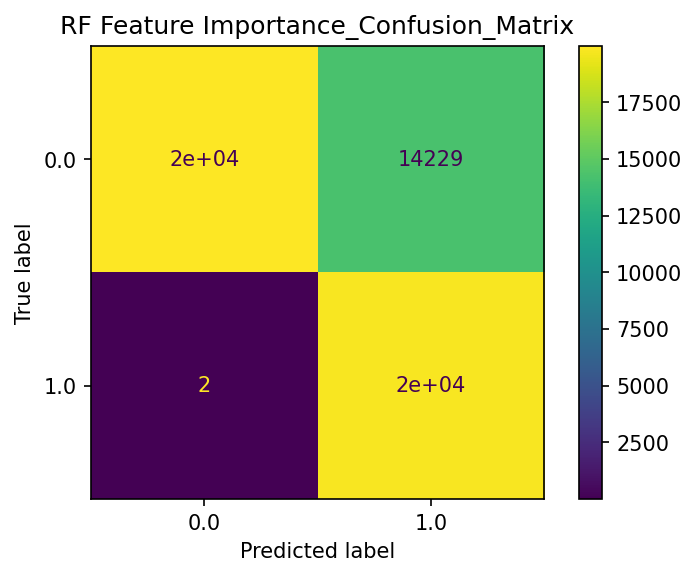

2022-02-07 21:37:27.671574 - Model performance dataframe created Successfully!
2022-02-07 21:37:27.674566 - Model training started!


X has feature names, but RandomForestClassifier was fitted without feature names
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but RandomForestClassifier was fitted without feature names


<Figure size 900x600 with 0 Axes>

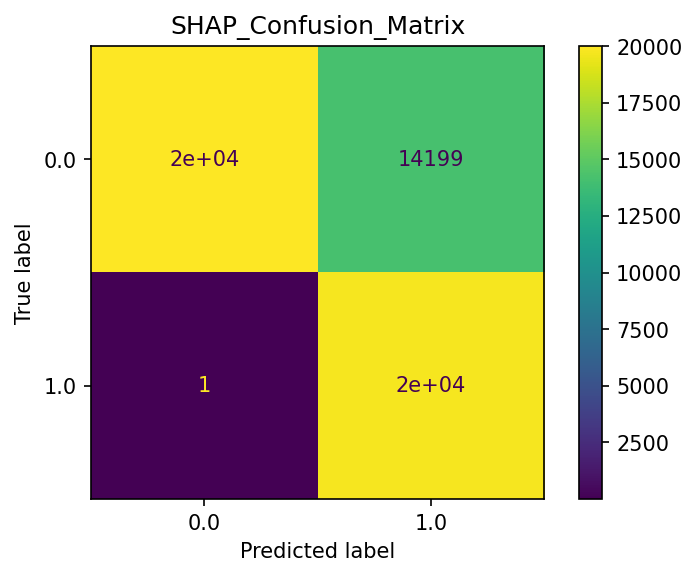

2022-02-07 21:42:47.923171 - Model performance dataframe created Successfully!
2022-02-07 21:42:47.927160 - Initializing ACCURACY Binary comparision Bar Chart visualization..
2022-02-07 21:42:48.211715 - ACCURACY BinaryClass comparision bar chart visualization generated Successfully!
2022-02-07 21:42:48.211715 - Initializing ACCURACY BinaryClass comparision Scatter Chart visualization..
2022-02-07 21:42:48.540396 - ACCURACY BinaryClass comparision line chart visualization generated Successfully!
2022-02-07 21:42:48.540396 - Initializing F1_SCORE Binary comparision Bar Chart visualization..
2022-02-07 21:42:48.816327 - F1_SCORE BinaryClass comparision bar chart visualization generated Successfully!
2022-02-07 21:42:48.816327 - Initializing F1_SCORE BinaryClass comparision Scatter Chart visualization..
2022-02-07 21:42:49.208787 - F1_SCORE BinaryClass comparision line chart visualization generated Successfully!
2022-02-07 21:42:49.208787 - Initializing PRECISION Binary comparision Bar Ch

 25%|██▌       | 1/4 [24:05<1:12:17, 1445.78s/it]

2022-02-07 21:42:55.292943 - Bar_Chart BinaryClass summary plot completed!
---------------------------------------------------------------------------------------------
Starting the Length of Features - 28
2022-02-07 21:42:55.294940 - Mutual Information feature selection Initialized..
2022-02-07 21:43:24.986073 - Mutual Information feature selection Successful!
2022-02-07 21:43:24.988033 - Correlation feature selection Initialized..
2022-02-07 21:43:25.527176 - Correlation feature selection Successful!
2022-02-07 21:43:25.527176 - RF Feature Importance feature selection Initialized..
2022-02-07 21:44:06.346631 - RF Feature Importance feature selection Successful!
2022-02-07 21:44:06.358319 - SHAP feature selection Initialized!
2022-02-07 21:44:34.370391 - SHAP feature selection Successful!
2022-02-07 21:44:34.387041 - Model training started!


X has feature names, but RandomForestClassifier was fitted without feature names
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but RandomForestClassifier was fitted without feature names


<Figure size 900x600 with 0 Axes>

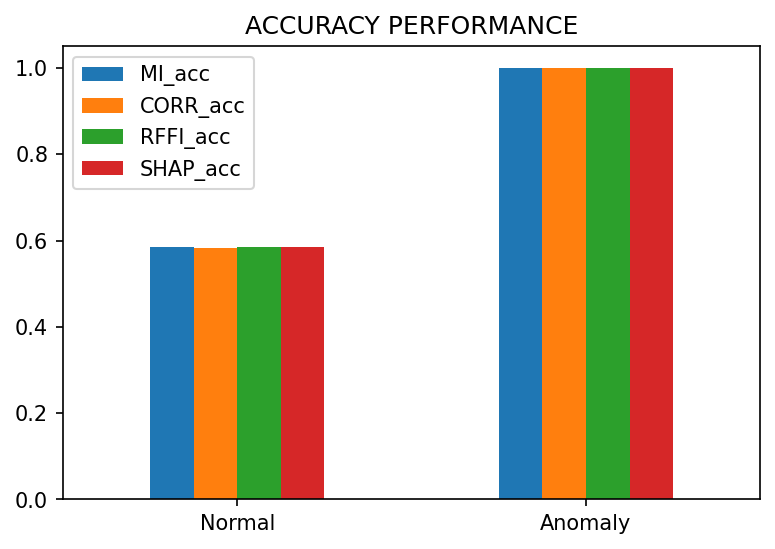

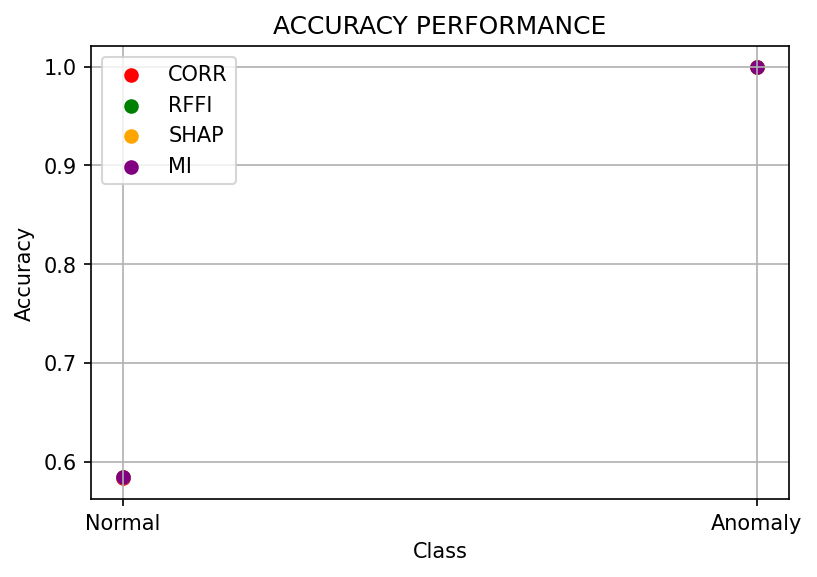

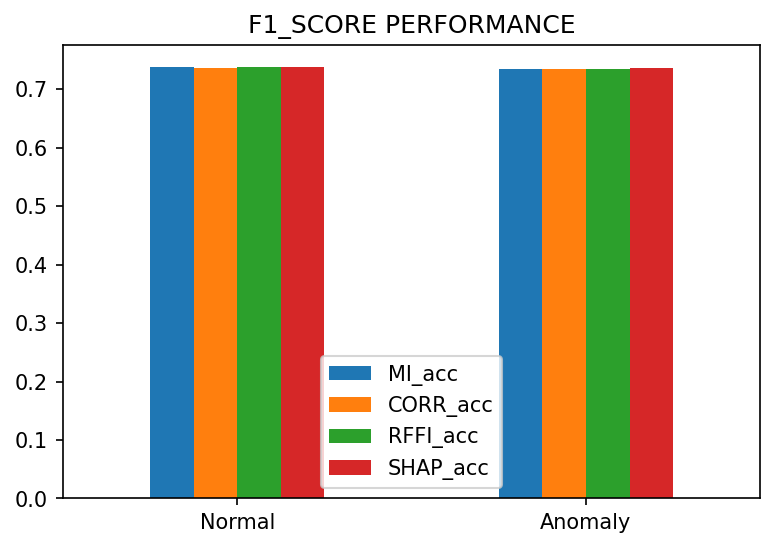

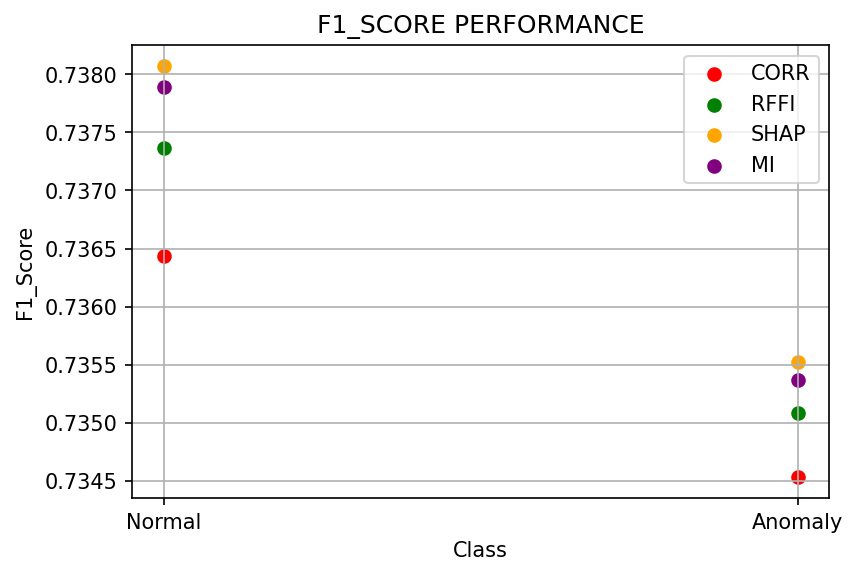

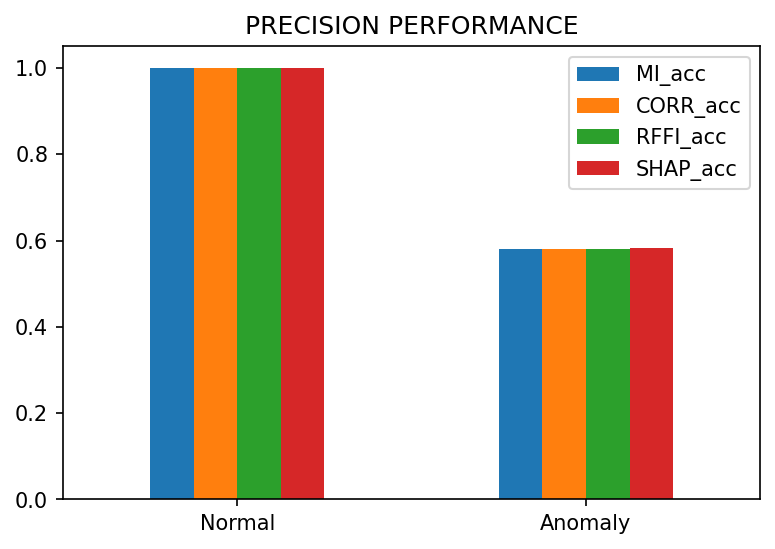

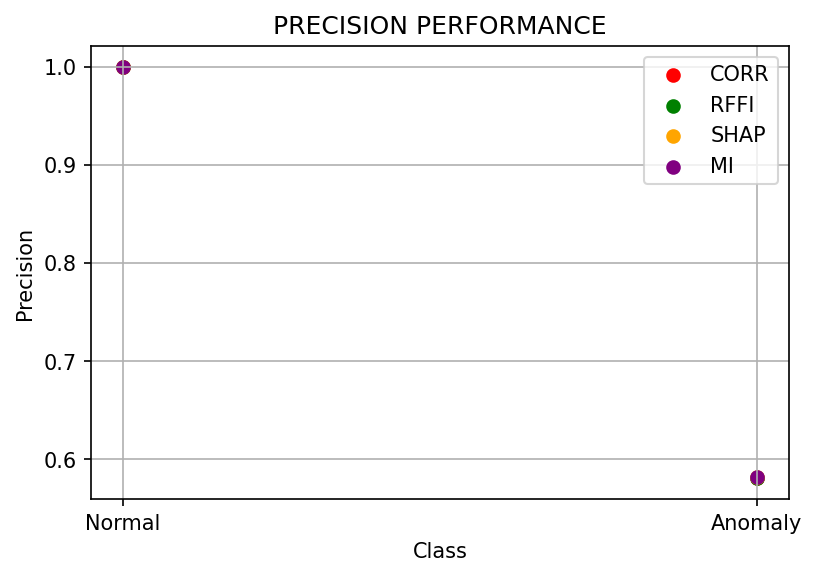

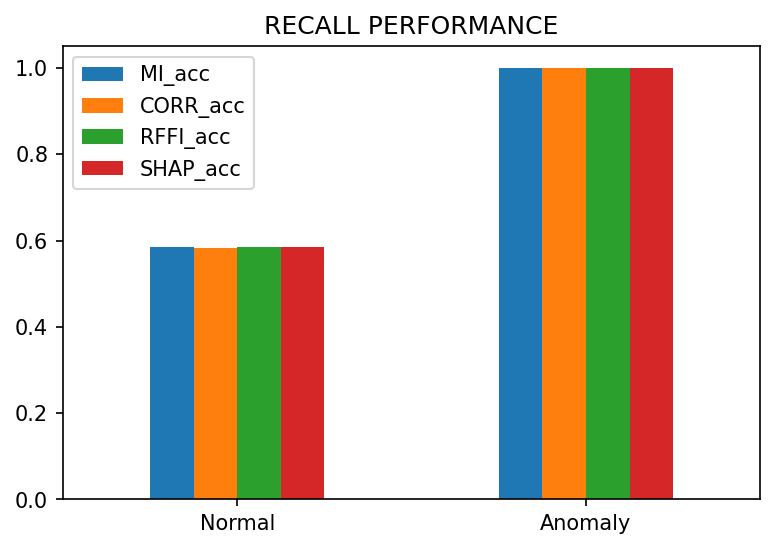

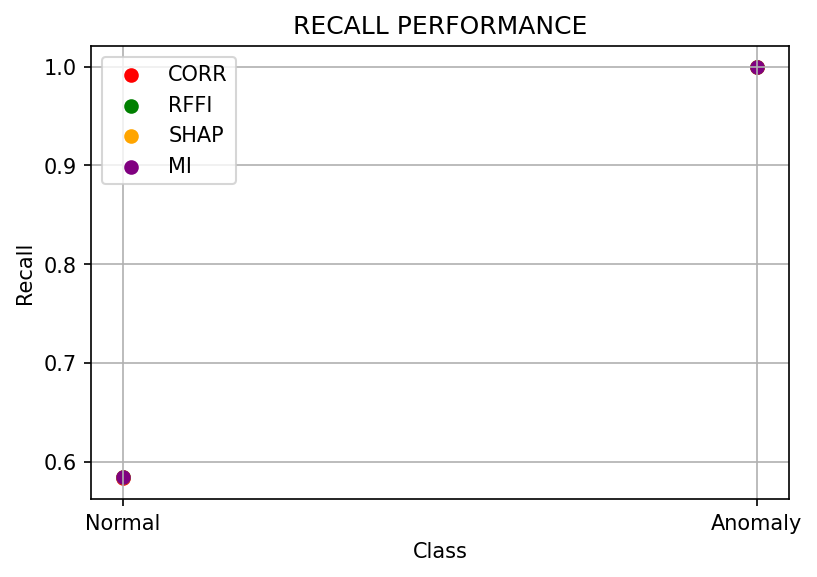

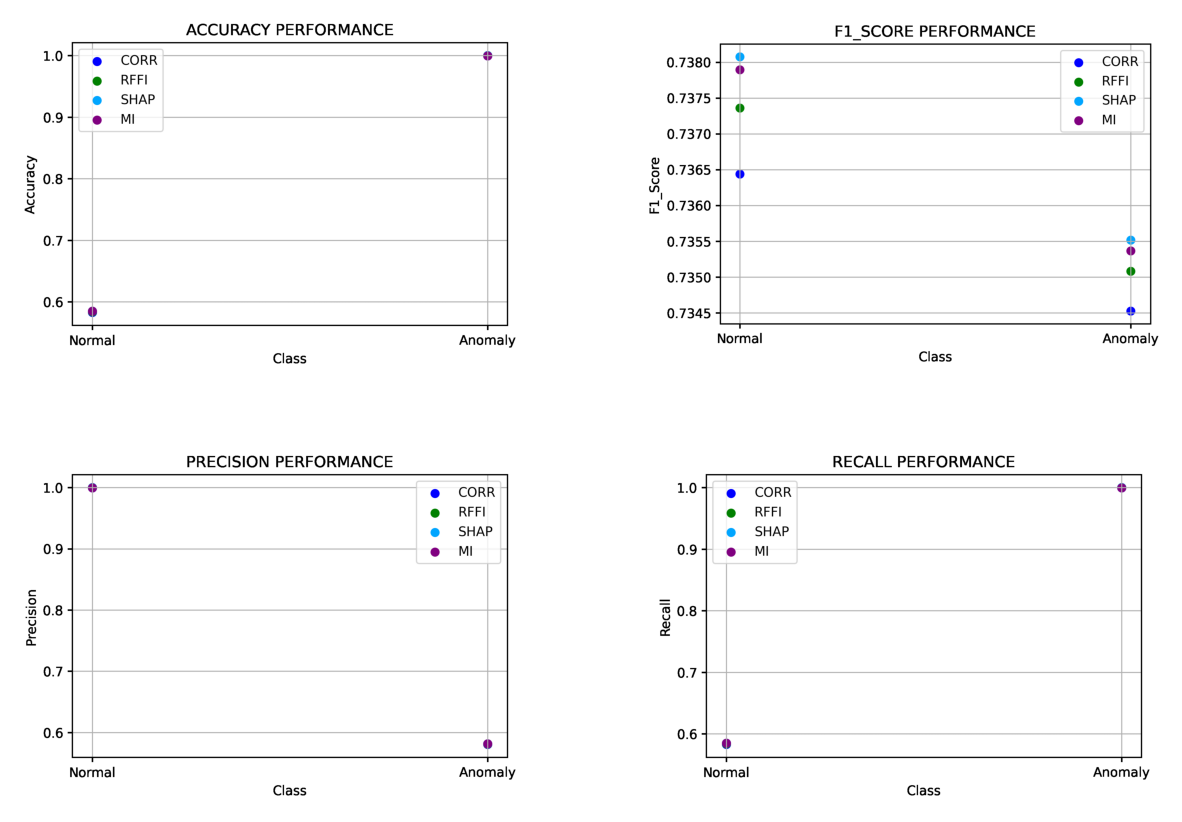

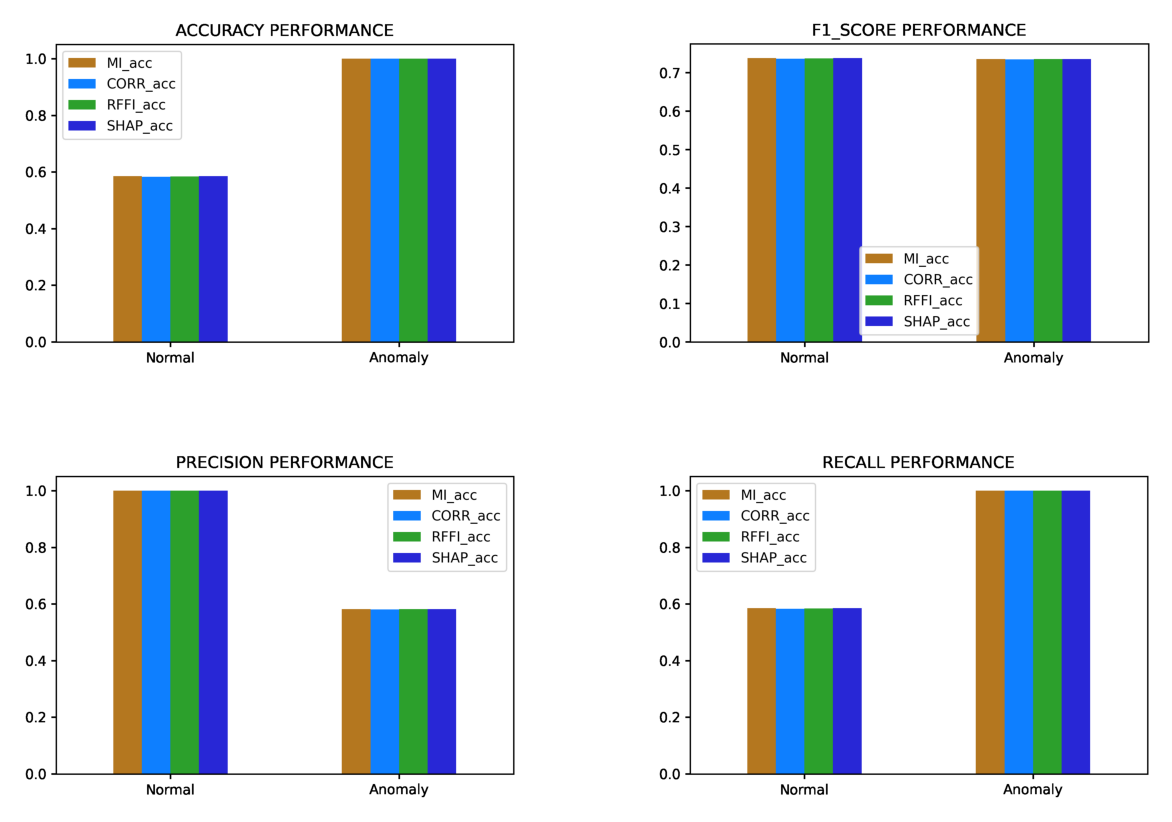

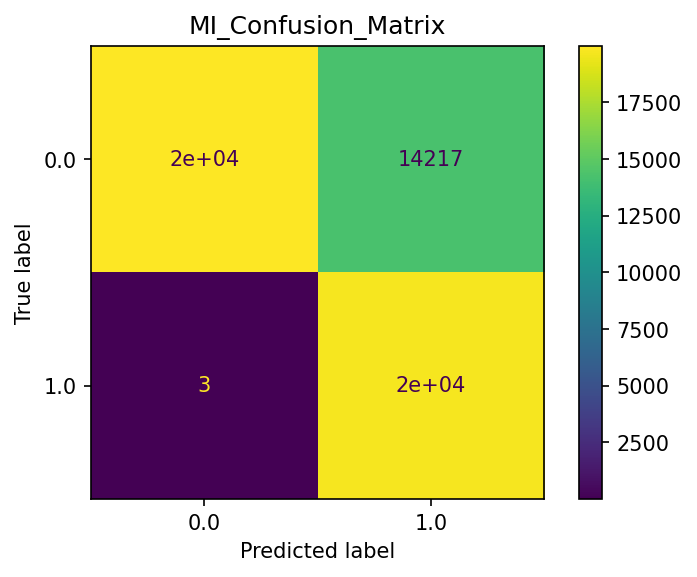

2022-02-07 21:50:24.246764 - Model performance dataframe created Successfully!
2022-02-07 21:50:24.246764 - Model training started!


X has feature names, but RandomForestClassifier was fitted without feature names
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but RandomForestClassifier was fitted without feature names


<Figure size 900x600 with 0 Axes>

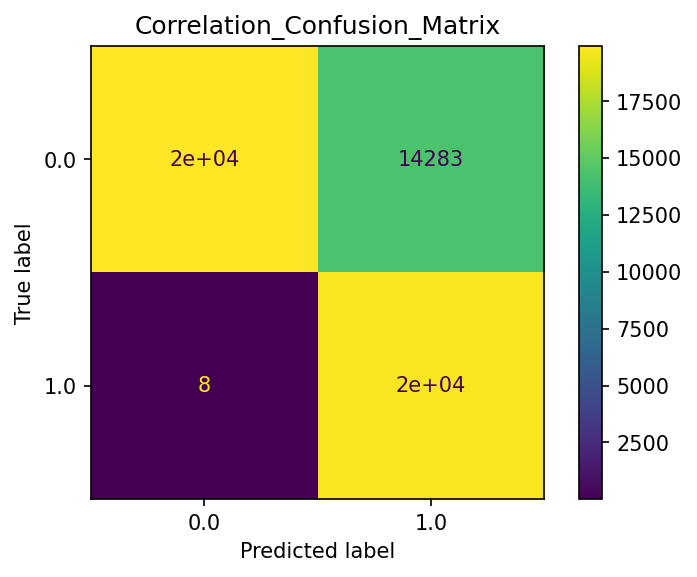

2022-02-07 21:55:09.727053 - Model performance dataframe created Successfully!
2022-02-07 21:55:09.729013 - Model training started!


X has feature names, but RandomForestClassifier was fitted without feature names
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but RandomForestClassifier was fitted without feature names


<Figure size 900x600 with 0 Axes>

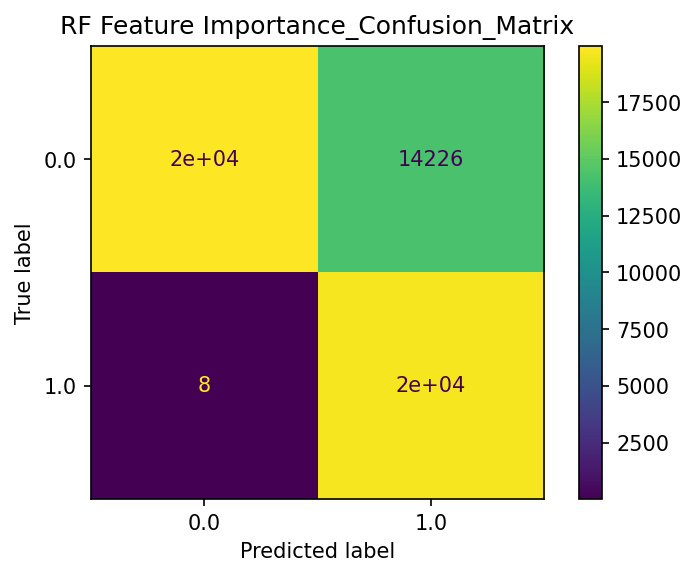

2022-02-07 22:01:24.709888 - Model performance dataframe created Successfully!
2022-02-07 22:01:24.712879 - Model training started!


X has feature names, but RandomForestClassifier was fitted without feature names
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but RandomForestClassifier was fitted without feature names


<Figure size 900x600 with 0 Axes>

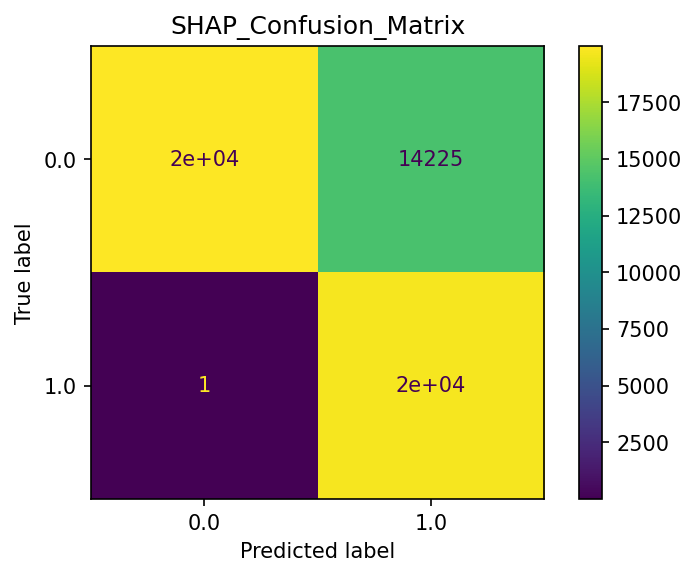

2022-02-07 22:06:23.150961 - Model performance dataframe created Successfully!
2022-02-07 22:06:23.150961 - Initializing ACCURACY Binary comparision Bar Chart visualization..
2022-02-07 22:06:23.369662 - ACCURACY BinaryClass comparision bar chart visualization generated Successfully!
2022-02-07 22:06:23.369662 - Initializing ACCURACY BinaryClass comparision Scatter Chart visualization..
2022-02-07 22:06:23.648355 - ACCURACY BinaryClass comparision line chart visualization generated Successfully!
2022-02-07 22:06:23.648355 - Initializing F1_SCORE Binary comparision Bar Chart visualization..
2022-02-07 22:06:23.871374 - F1_SCORE BinaryClass comparision bar chart visualization generated Successfully!
2022-02-07 22:06:23.871374 - Initializing F1_SCORE BinaryClass comparision Scatter Chart visualization..
2022-02-07 22:06:24.164176 - F1_SCORE BinaryClass comparision line chart visualization generated Successfully!
2022-02-07 22:06:24.164176 - Initializing PRECISION Binary comparision Bar Ch

 50%|█████     | 2/4 [47:39<47:33, 1426.74s/it]  

2022-02-07 22:06:28.703587 - Bar_Chart BinaryClass summary plot completed!
---------------------------------------------------------------------------------------------
Starting the Length of Features - 21
2022-02-07 22:06:28.703587 - Mutual Information feature selection Initialized..
2022-02-07 22:06:55.533791 - Mutual Information feature selection Successful!
2022-02-07 22:06:55.533791 - Correlation feature selection Initialized..
2022-02-07 22:06:56.053327 - Correlation feature selection Successful!
2022-02-07 22:06:56.053327 - RF Feature Importance feature selection Initialized..
2022-02-07 22:07:32.815004 - RF Feature Importance feature selection Successful!
2022-02-07 22:07:32.830593 - SHAP feature selection Initialized!
2022-02-07 22:07:58.488802 - SHAP feature selection Successful!
2022-02-07 22:07:58.520047 - Model training started!


X has feature names, but RandomForestClassifier was fitted without feature names
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but RandomForestClassifier was fitted without feature names


<Figure size 900x600 with 0 Axes>

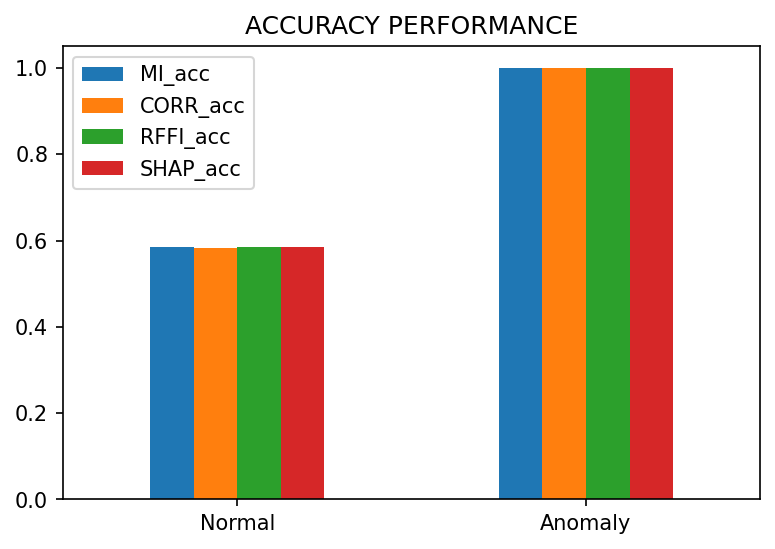

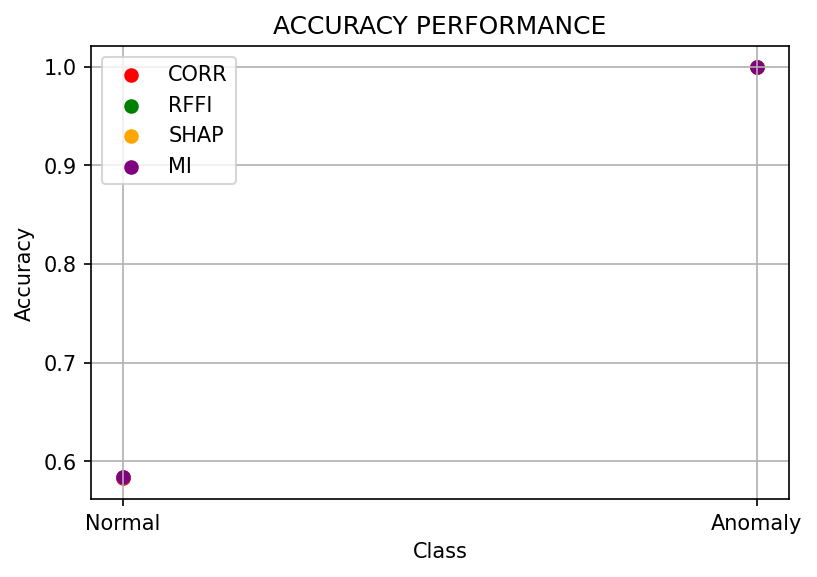

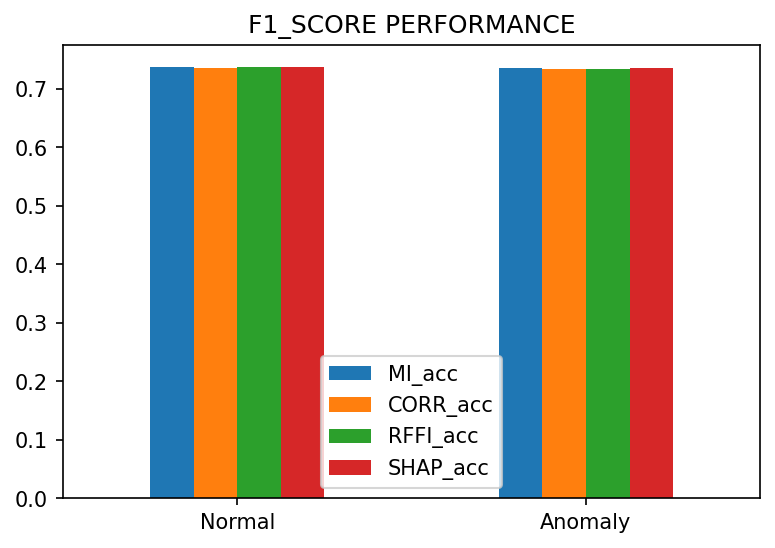

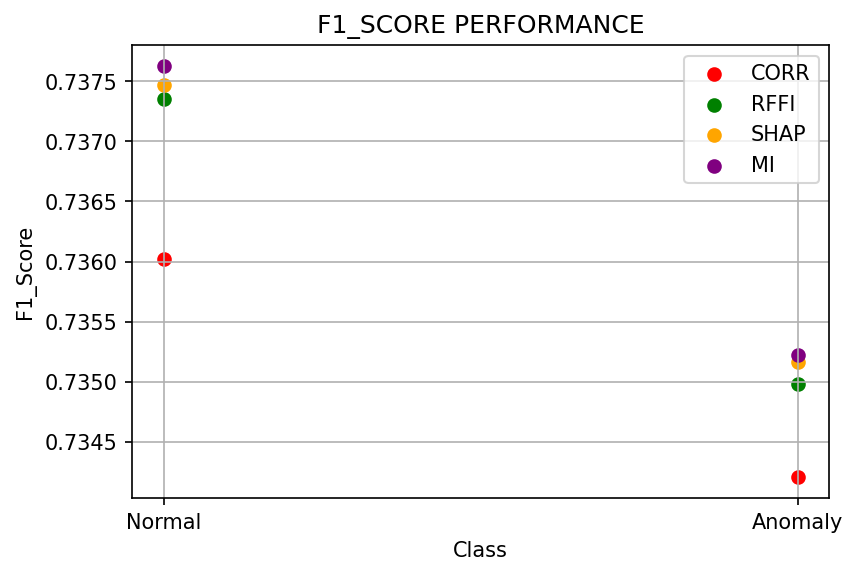

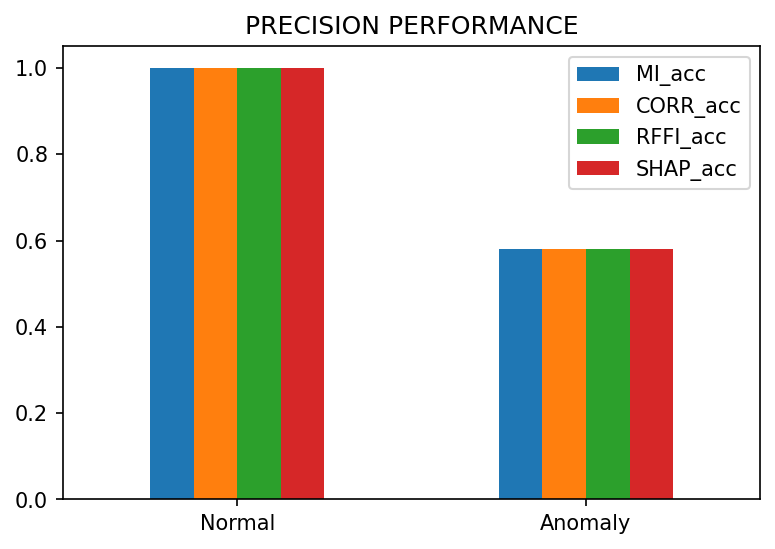

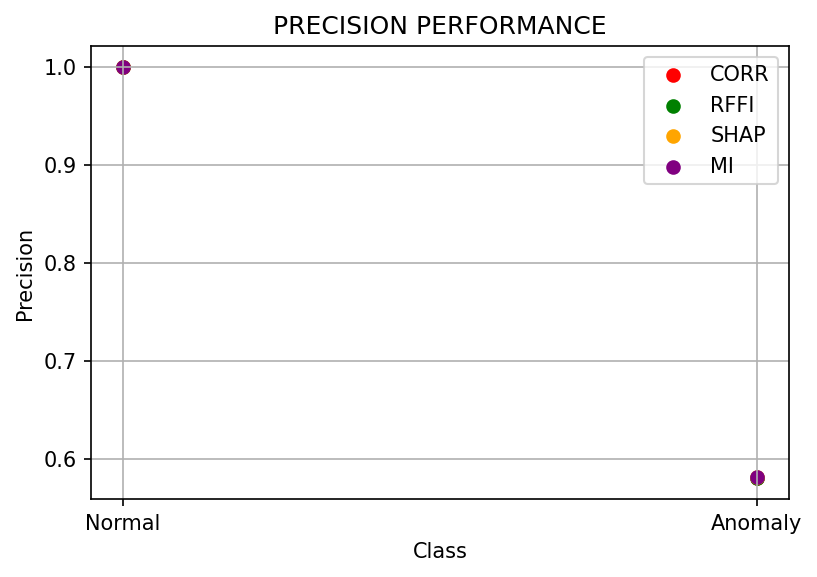

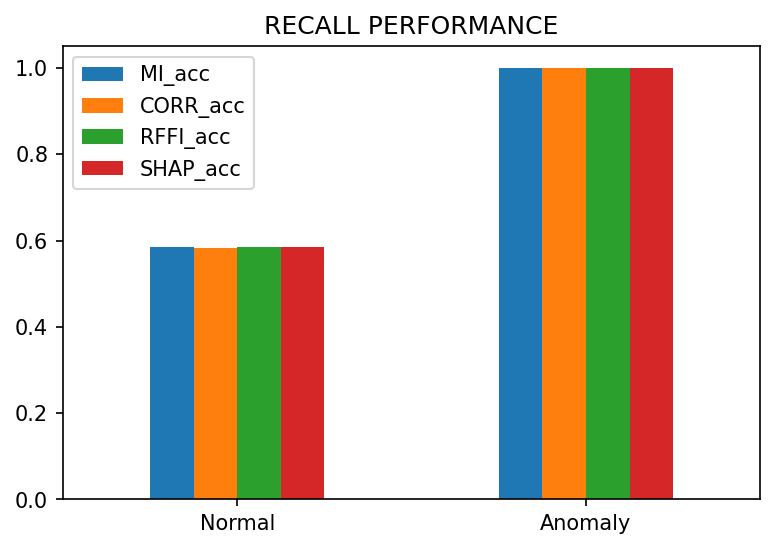

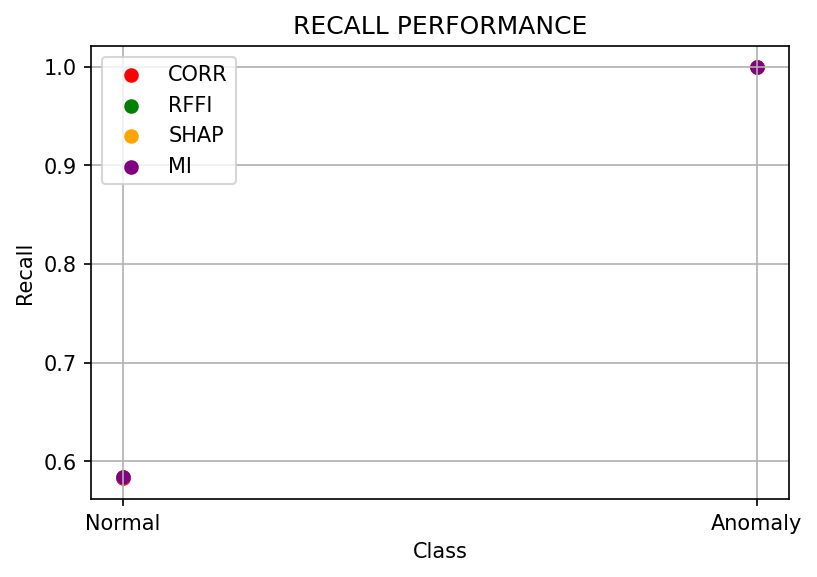

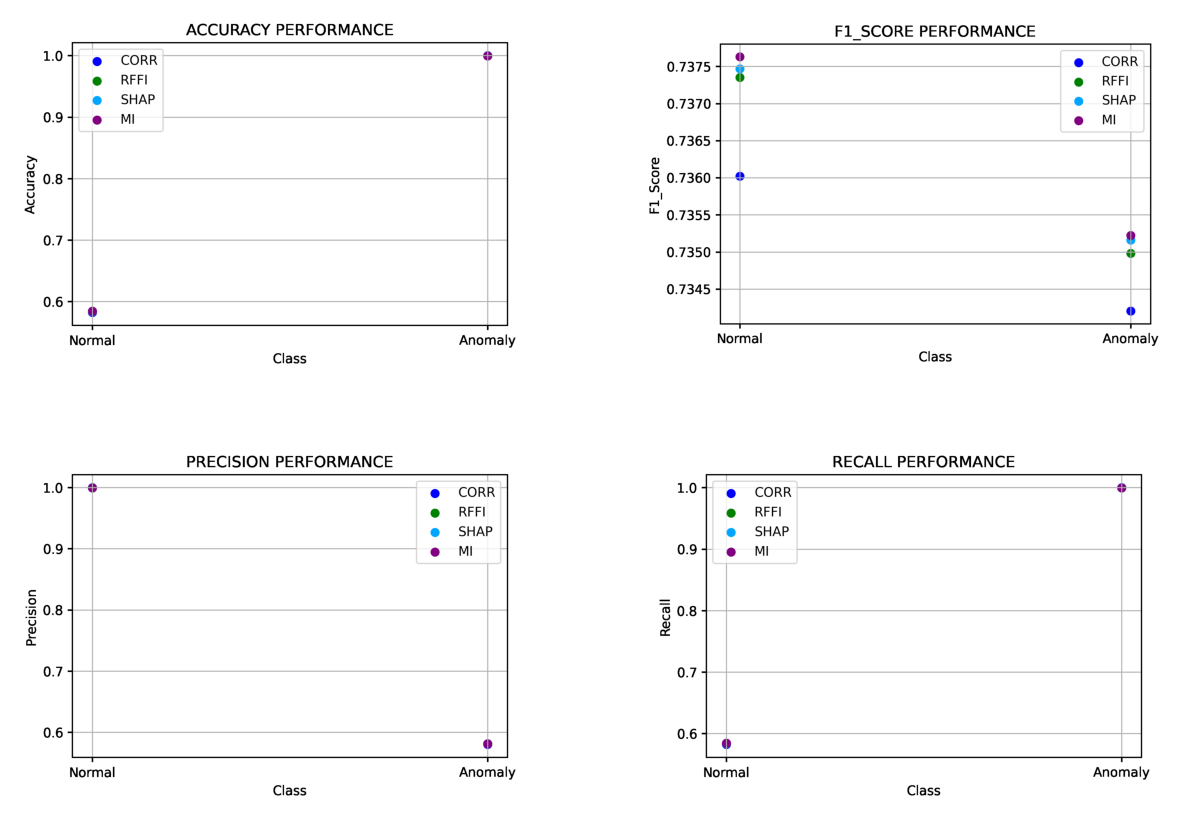

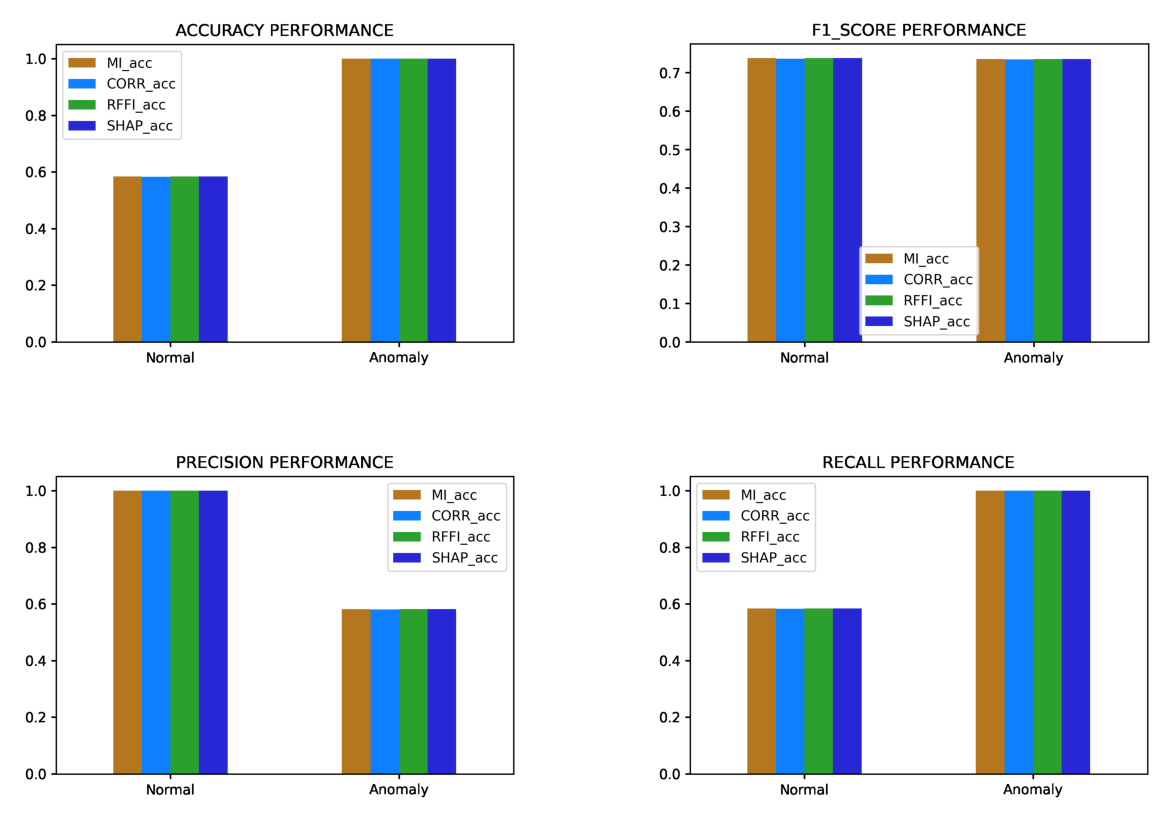

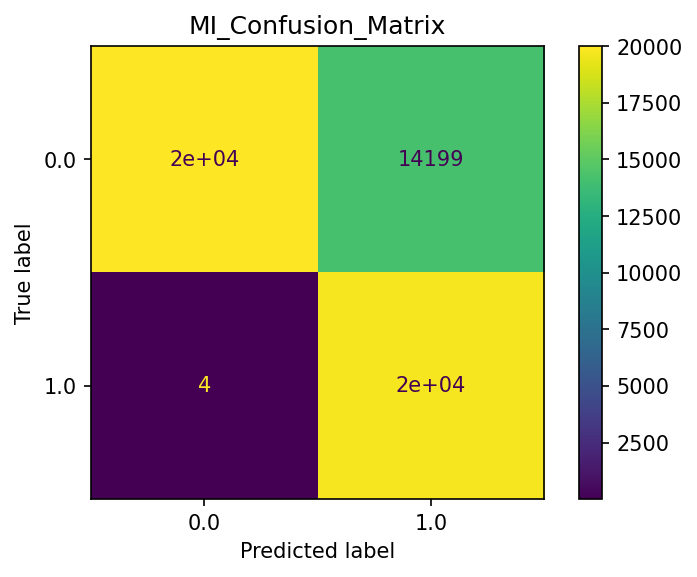

2022-02-07 22:12:28.726791 - Model performance dataframe created Successfully!
2022-02-07 22:12:28.742414 - Model training started!


X has feature names, but RandomForestClassifier was fitted without feature names
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but RandomForestClassifier was fitted without feature names


<Figure size 900x600 with 0 Axes>

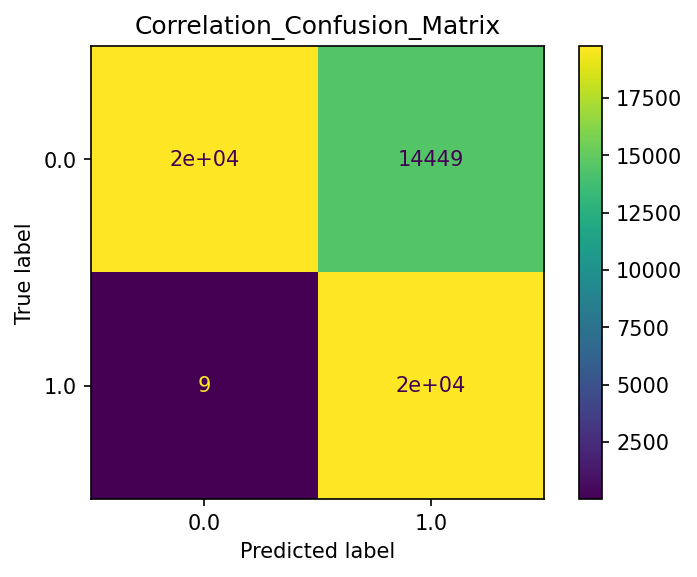

2022-02-07 22:15:46.743771 - Model performance dataframe created Successfully!
2022-02-07 22:15:46.743771 - Model training started!


X has feature names, but RandomForestClassifier was fitted without feature names
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but RandomForestClassifier was fitted without feature names


<Figure size 900x600 with 0 Axes>

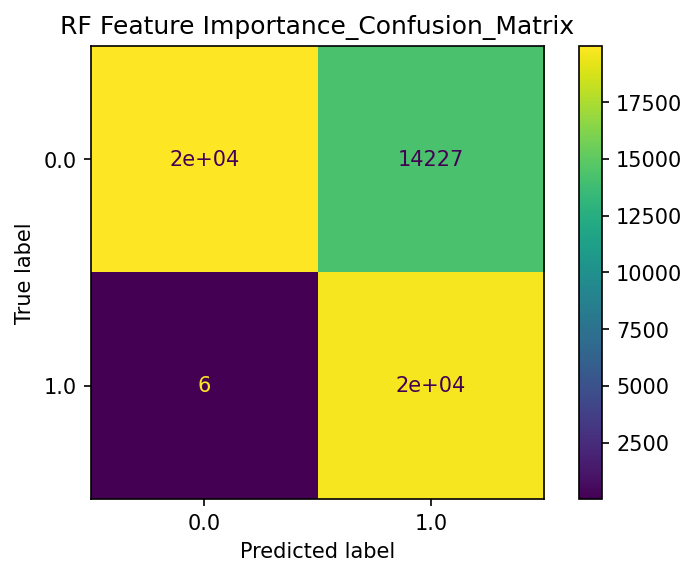

2022-02-07 22:20:33.548089 - Model performance dataframe created Successfully!
2022-02-07 22:20:33.548089 - Model training started!


X has feature names, but RandomForestClassifier was fitted without feature names
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but RandomForestClassifier was fitted without feature names


<Figure size 900x600 with 0 Axes>

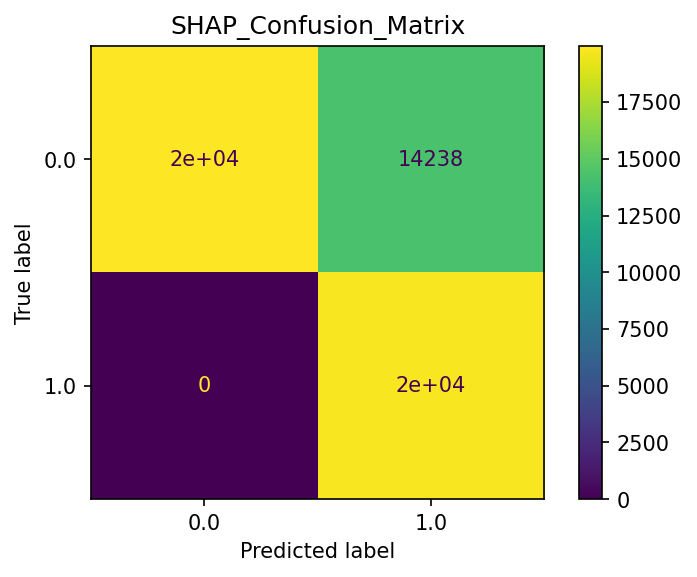

2022-02-07 22:24:28.852891 - Model performance dataframe created Successfully!
2022-02-07 22:24:28.852891 - Initializing ACCURACY Binary comparision Bar Chart visualization..
2022-02-07 22:24:29.180939 - ACCURACY BinaryClass comparision bar chart visualization generated Successfully!
2022-02-07 22:24:29.180939 - Initializing ACCURACY BinaryClass comparision Scatter Chart visualization..
2022-02-07 22:24:29.618367 - ACCURACY BinaryClass comparision line chart visualization generated Successfully!
2022-02-07 22:24:29.618367 - Initializing F1_SCORE Binary comparision Bar Chart visualization..
2022-02-07 22:24:29.883930 - F1_SCORE BinaryClass comparision bar chart visualization generated Successfully!
2022-02-07 22:24:29.883930 - Initializing F1_SCORE BinaryClass comparision Scatter Chart visualization..
2022-02-07 22:24:30.258845 - F1_SCORE BinaryClass comparision line chart visualization generated Successfully!
2022-02-07 22:24:30.258845 - Initializing PRECISION Binary comparision Bar Ch

 75%|███████▌  | 3/4 [1:05:47<21:12, 1272.17s/it]

2022-02-07 22:24:36.929115 - Bar_Chart BinaryClass summary plot completed!
---------------------------------------------------------------------------------------------
Starting the Length of Features - 11
2022-02-07 22:24:36.929115 - Mutual Information feature selection Initialized..
2022-02-07 22:25:06.000441 - Mutual Information feature selection Successful!
2022-02-07 22:25:06.000441 - Correlation feature selection Initialized..
2022-02-07 22:25:06.515939 - Correlation feature selection Successful!
2022-02-07 22:25:06.515939 - RF Feature Importance feature selection Initialized..
2022-02-07 22:25:48.249357 - RF Feature Importance feature selection Successful!
2022-02-07 22:25:48.264978 - SHAP feature selection Initialized!
2022-02-07 22:26:14.771795 - SHAP feature selection Successful!
2022-02-07 22:26:14.787387 - Model training started!


X has feature names, but RandomForestClassifier was fitted without feature names
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but RandomForestClassifier was fitted without feature names


<Figure size 900x600 with 0 Axes>

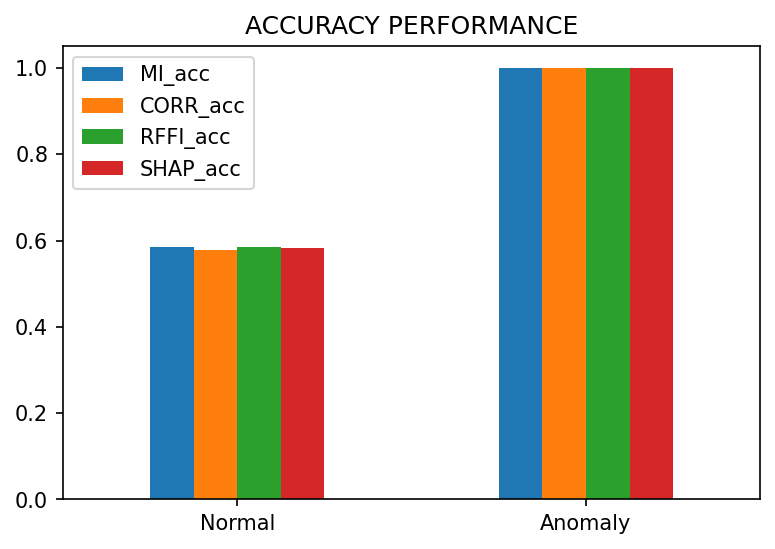

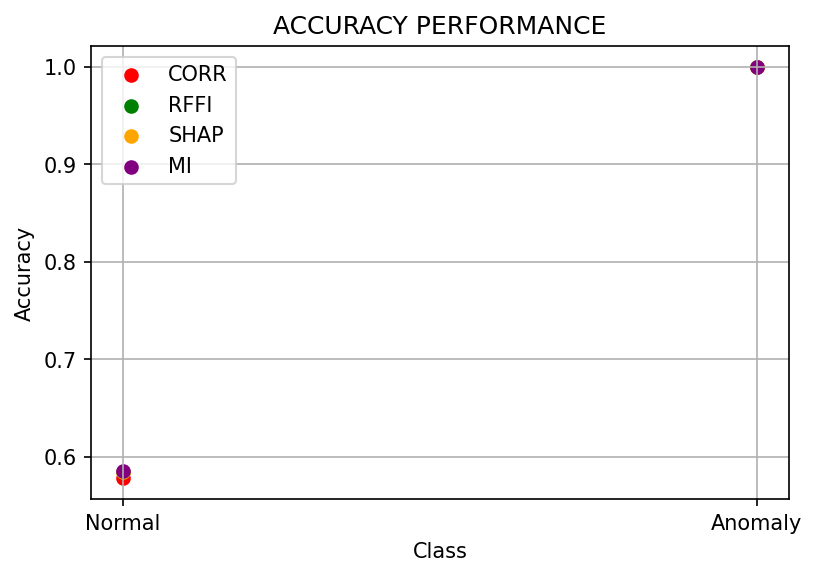

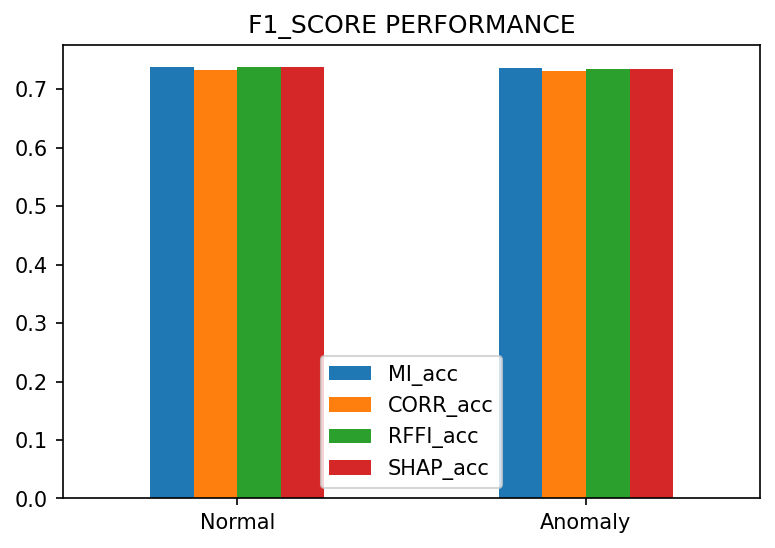

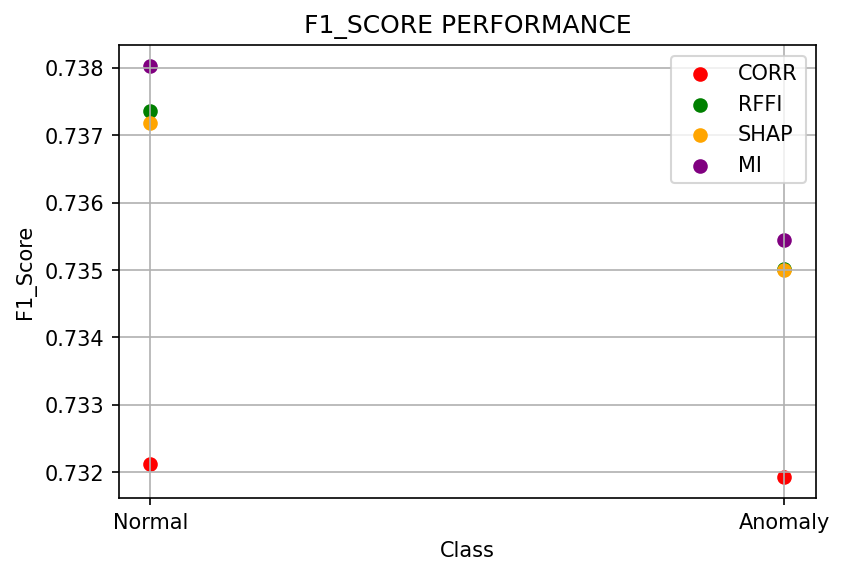

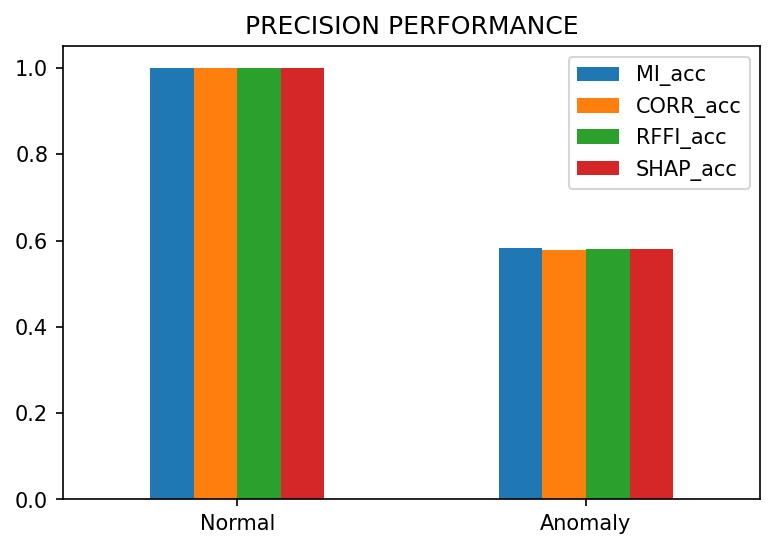

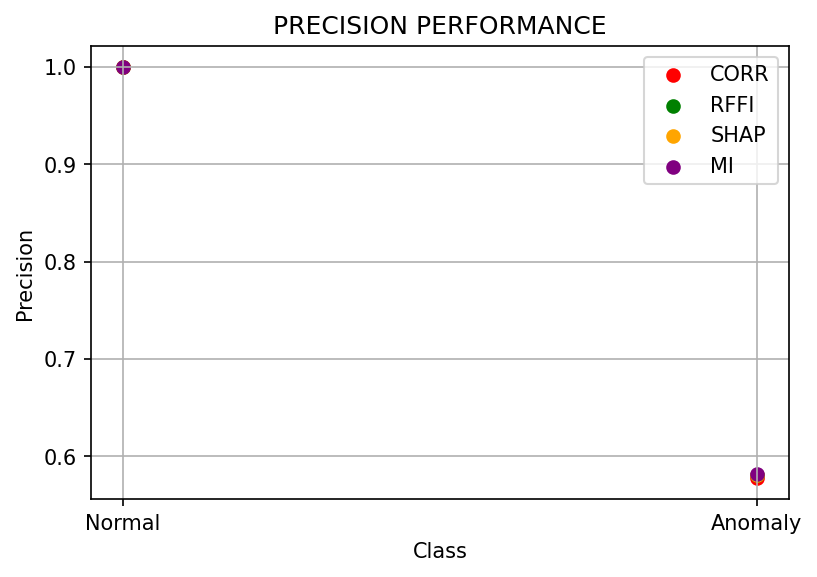

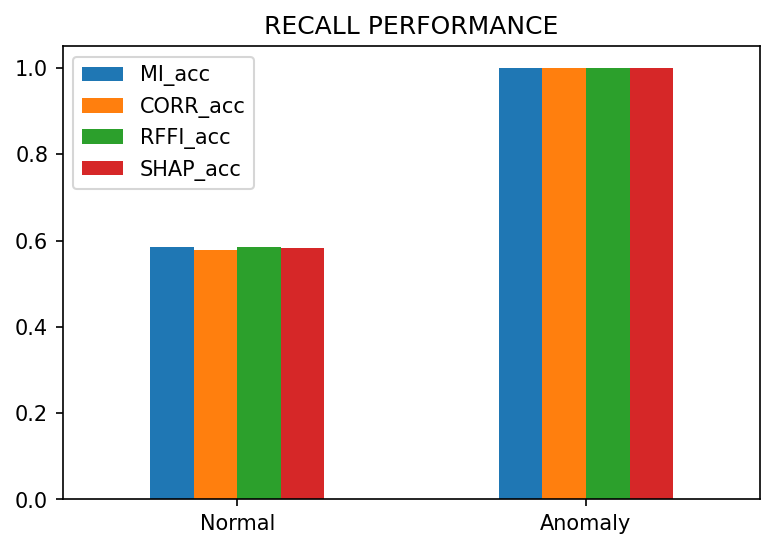

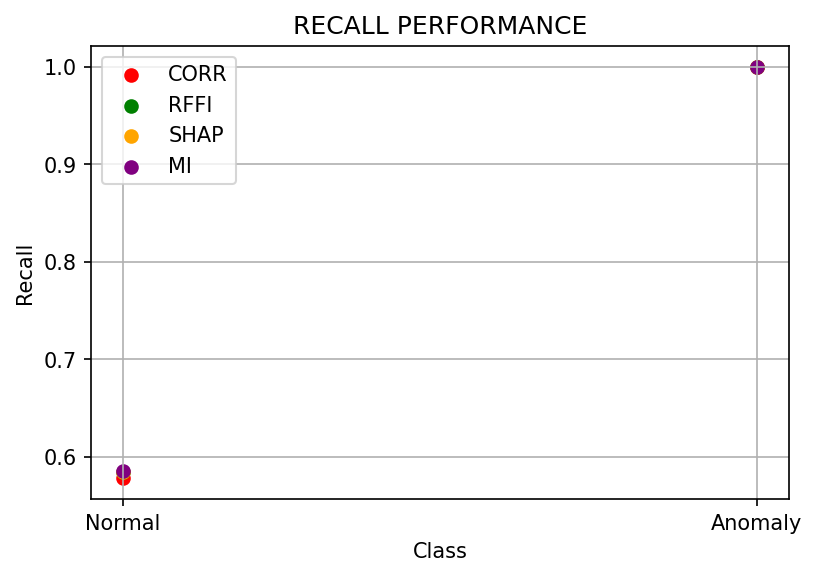

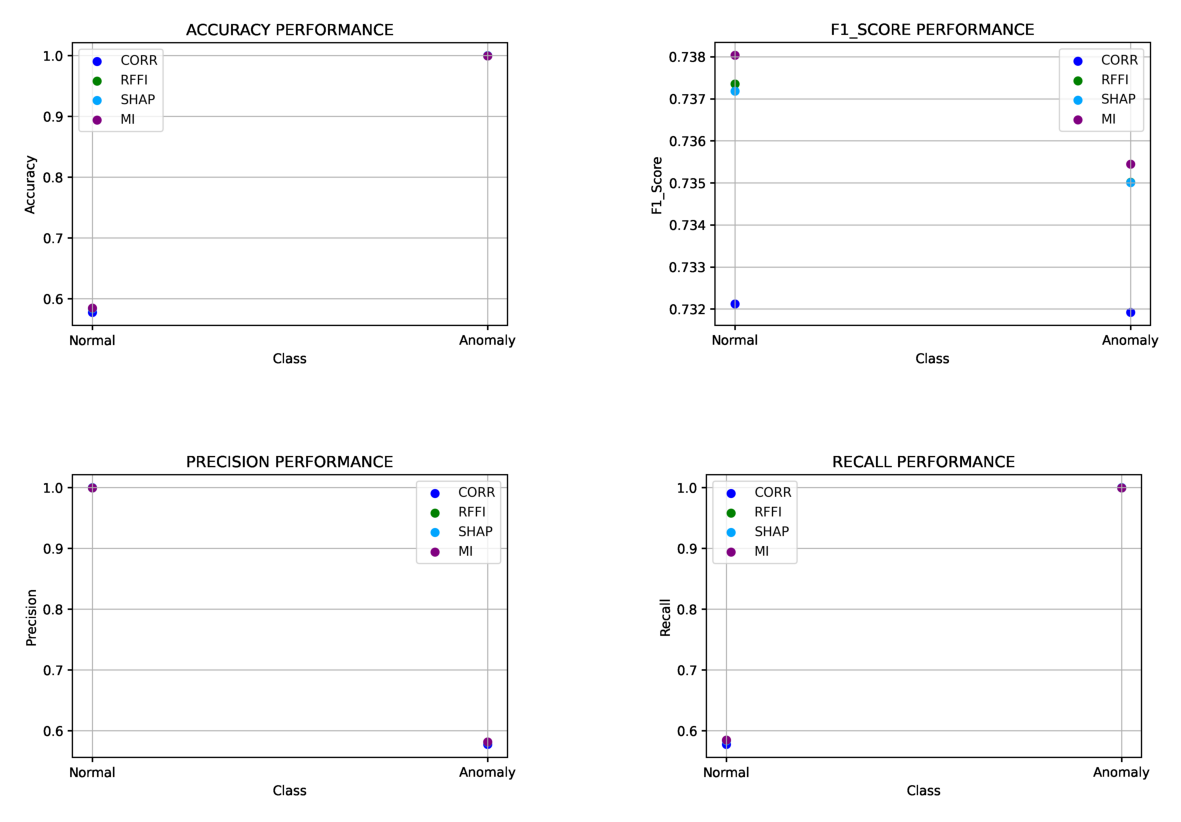

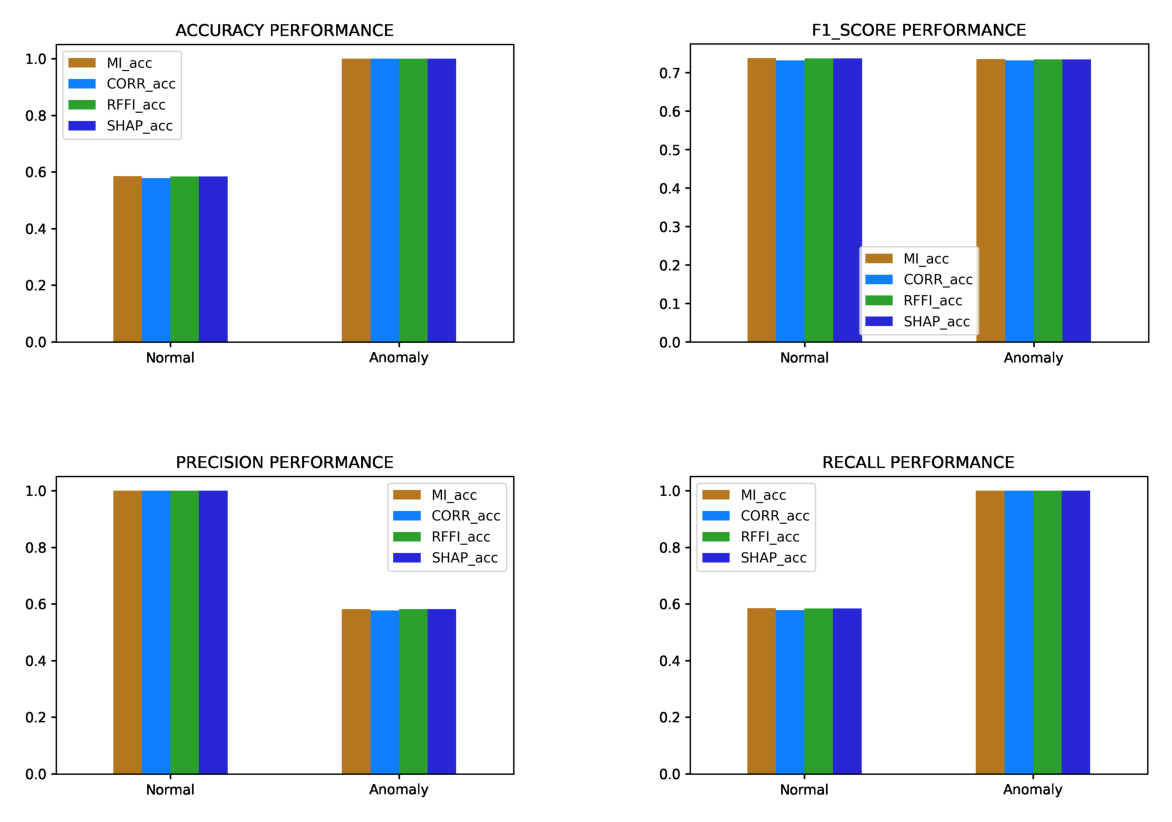

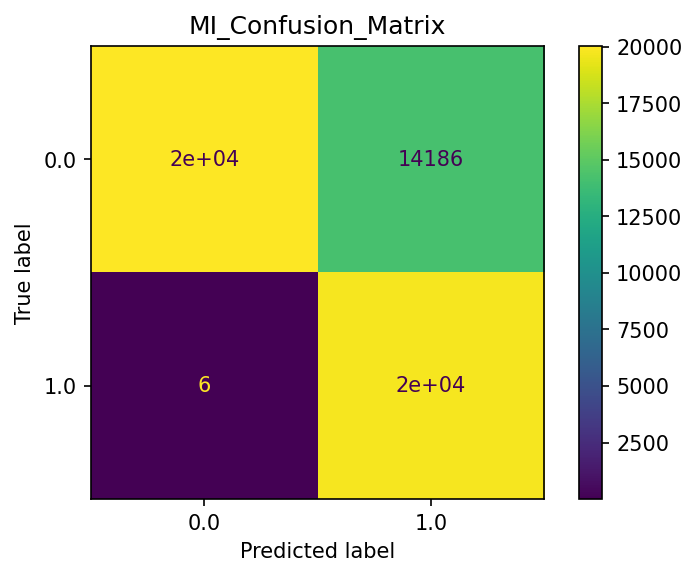

2022-02-07 22:30:17.395563 - Model performance dataframe created Successfully!
2022-02-07 22:30:17.396561 - Model training started!


X has feature names, but RandomForestClassifier was fitted without feature names
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but RandomForestClassifier was fitted without feature names


<Figure size 900x600 with 0 Axes>

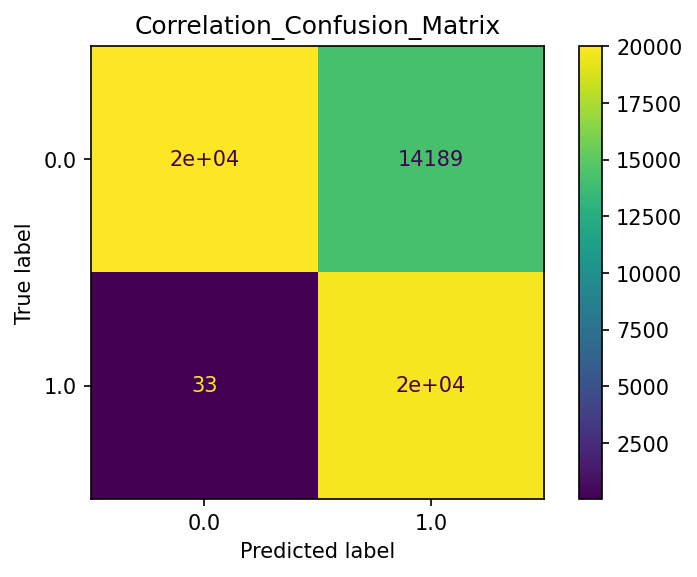

2022-02-07 22:34:58.202820 - Model performance dataframe created Successfully!
2022-02-07 22:34:58.212793 - Model training started!


X has feature names, but RandomForestClassifier was fitted without feature names
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but RandomForestClassifier was fitted without feature names


<Figure size 900x600 with 0 Axes>

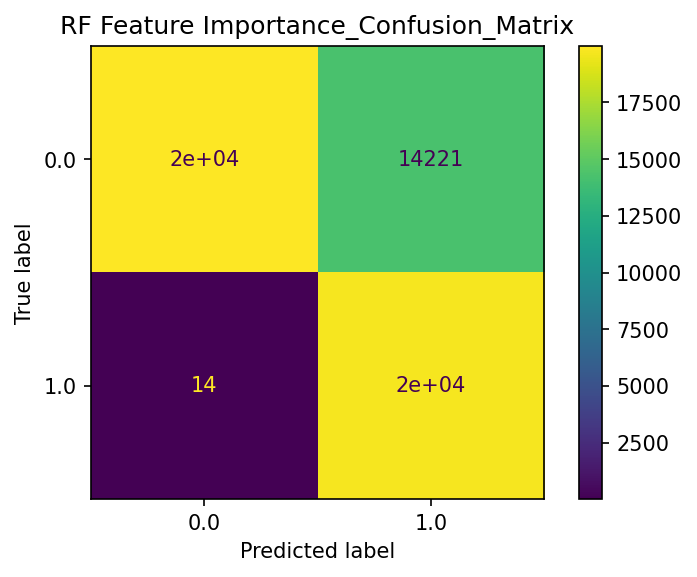

2022-02-07 22:39:34.172874 - Model performance dataframe created Successfully!
2022-02-07 22:39:34.174870 - Model training started!


X has feature names, but RandomForestClassifier was fitted without feature names
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
X has feature names, but RandomForestClassifier was fitted without feature names


<Figure size 900x600 with 0 Axes>

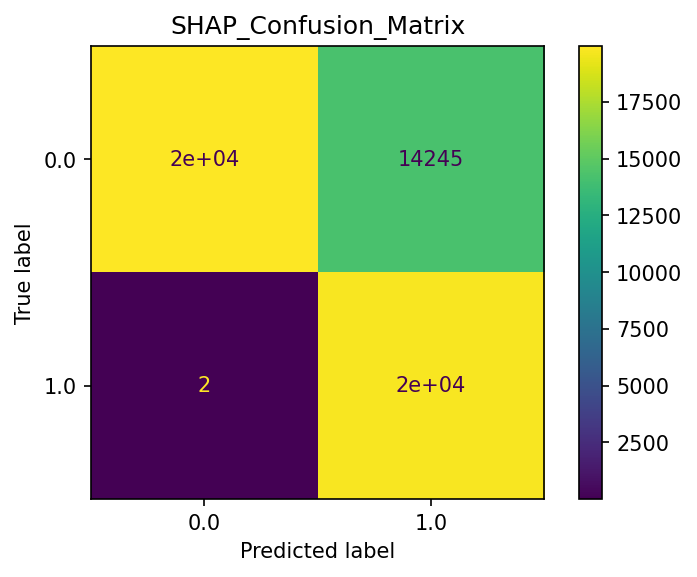

2022-02-07 22:42:01.735379 - Model performance dataframe created Successfully!
2022-02-07 22:42:01.737375 - Initializing ACCURACY Binary comparision Bar Chart visualization..
2022-02-07 22:42:02.071619 - ACCURACY BinaryClass comparision bar chart visualization generated Successfully!
2022-02-07 22:42:02.071619 - Initializing ACCURACY BinaryClass comparision Scatter Chart visualization..
2022-02-07 22:42:02.448232 - ACCURACY BinaryClass comparision line chart visualization generated Successfully!
2022-02-07 22:42:02.448232 - Initializing F1_SCORE Binary comparision Bar Chart visualization..
2022-02-07 22:42:02.694631 - F1_SCORE BinaryClass comparision bar chart visualization generated Successfully!
2022-02-07 22:42:02.694631 - Initializing F1_SCORE BinaryClass comparision Scatter Chart visualization..
2022-02-07 22:42:03.045666 - F1_SCORE BinaryClass comparision line chart visualization generated Successfully!
2022-02-07 22:42:03.045666 - Initializing PRECISION Binary comparision Bar Ch

100%|██████████| 4/4 [1:23:19<00:00, 1249.83s/it]

2022-02-07 22:42:08.831061 - Bar_Chart BinaryClass summary plot completed!
---------------------------------------------------------------------------------------------


<Figure size 900x600 with 0 Axes>

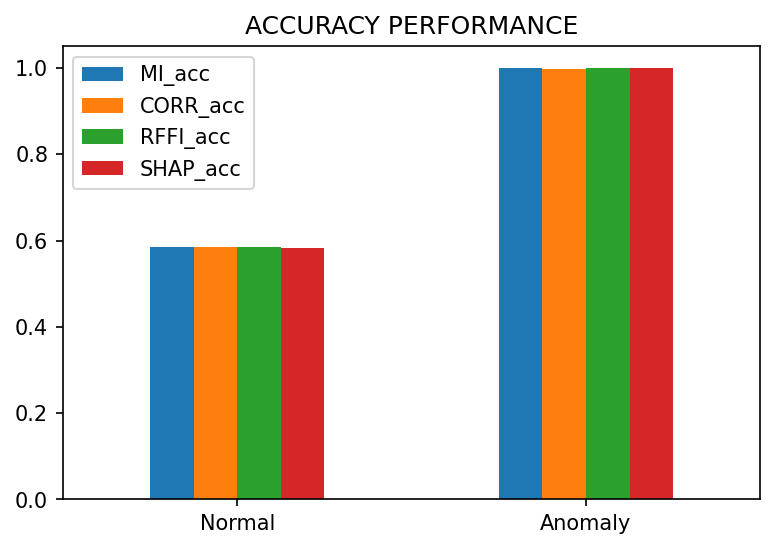

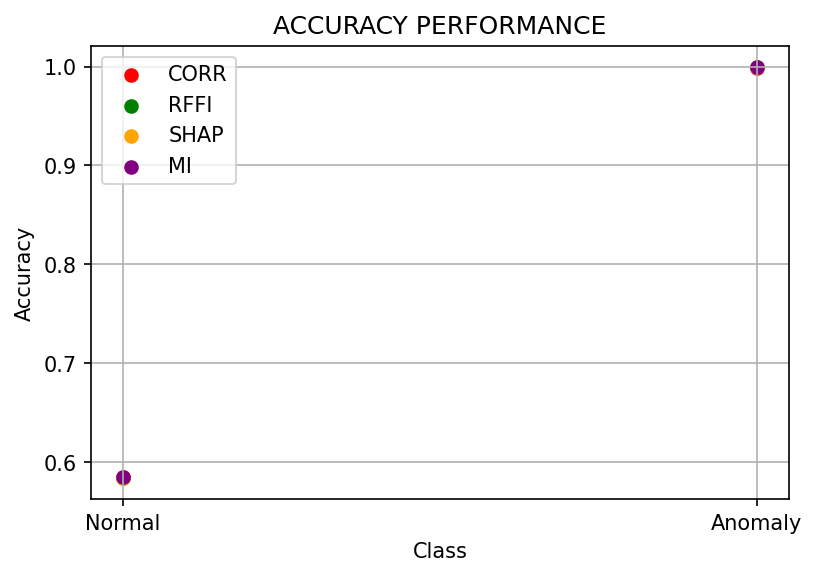

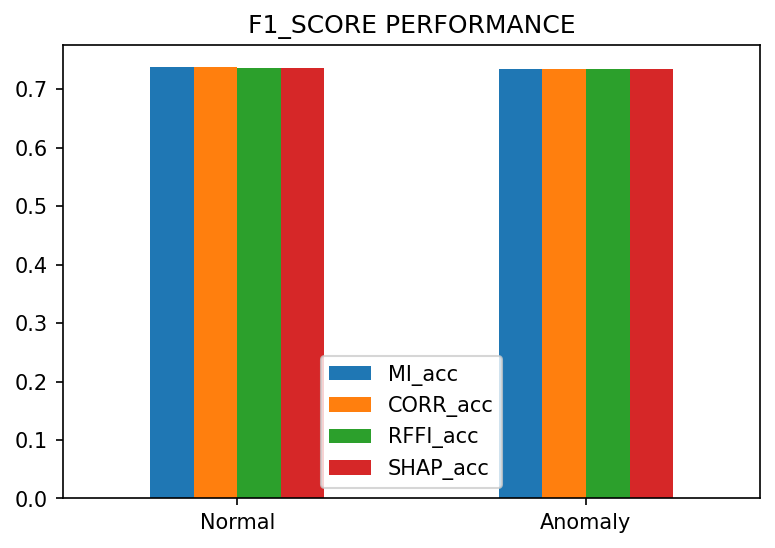

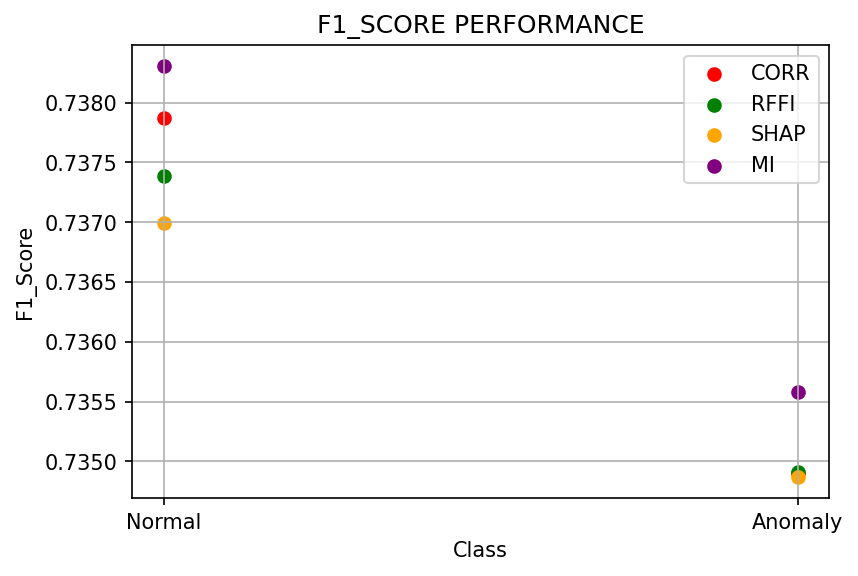

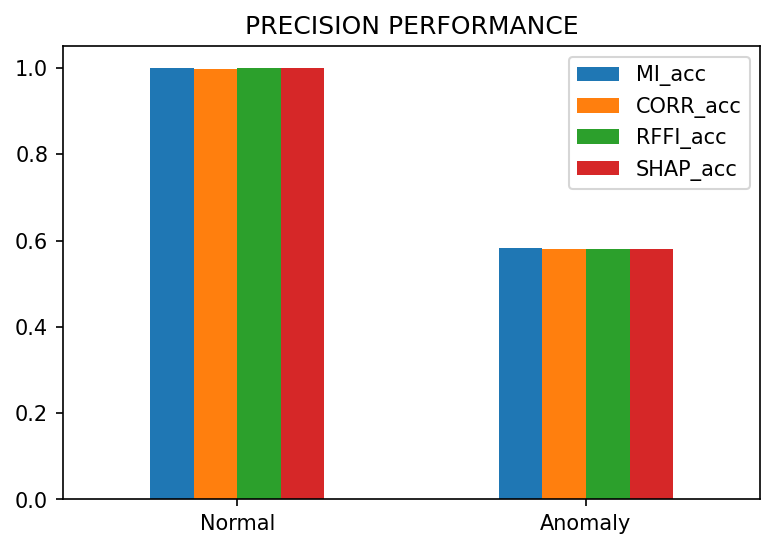

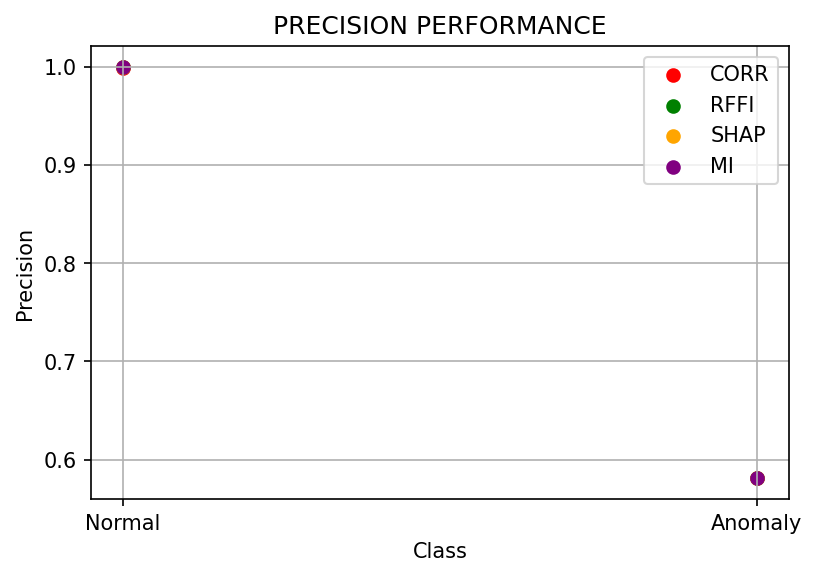

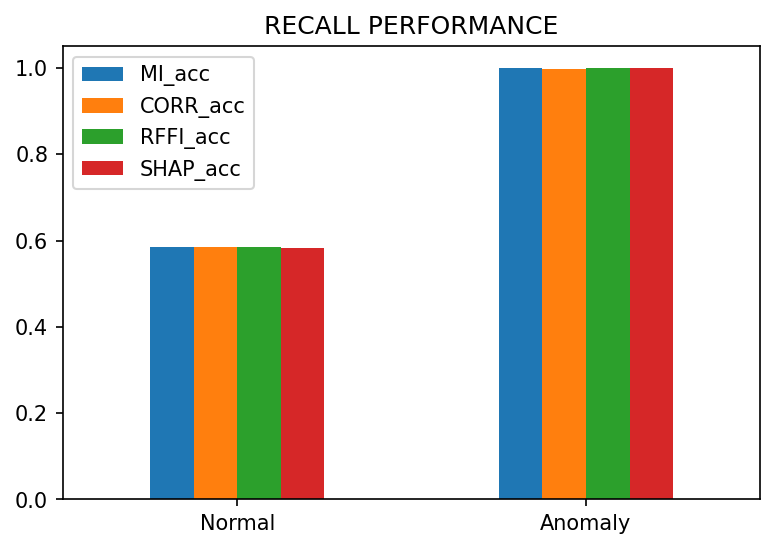

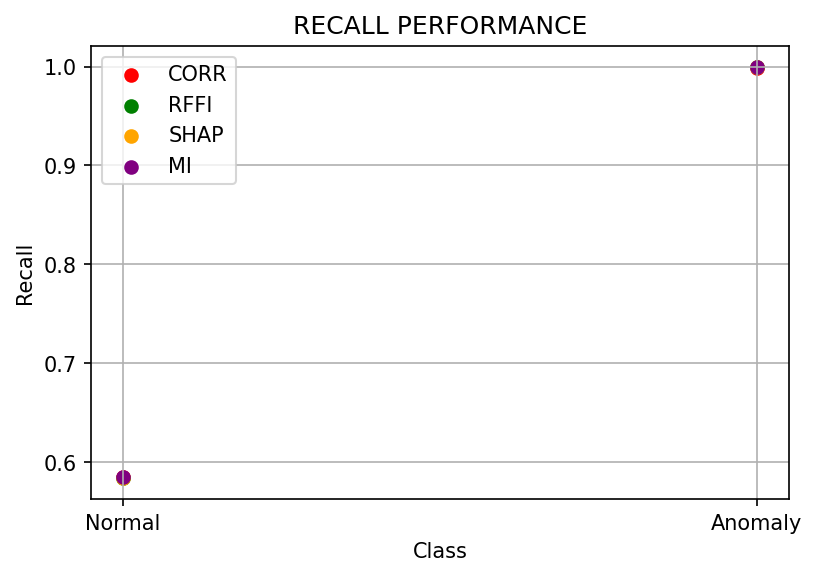

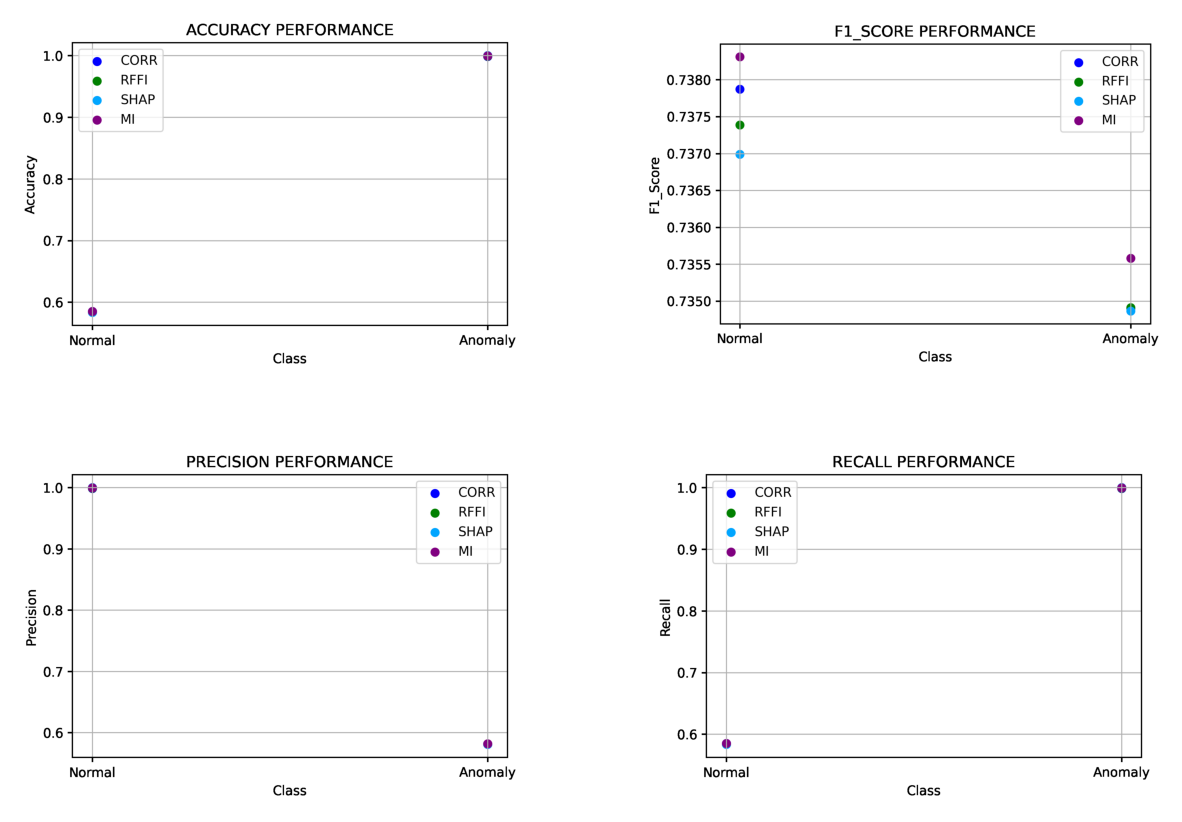

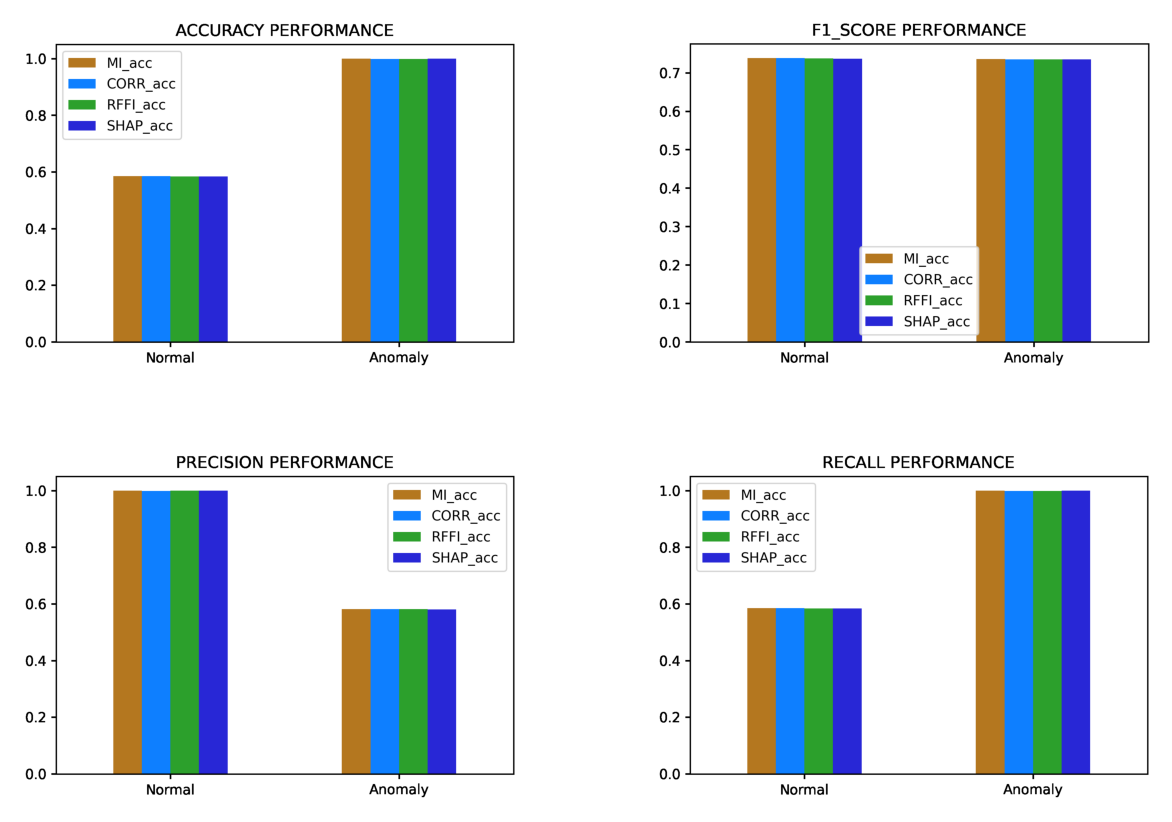

In [59]:
atype = 'BinaryClass'
dataset = 'UNSW'

k_list = [32,28,21,11]

for k in tqdm(k_list):
    
    print(f'Starting the Length of Features - {k}')

    MI_features = MI_topk_features(scaled_enc_df_train, k)
    CORR_features = CORR_topk_features(scaled_enc_df_train, k)
    RFFI_features = RFFI_topk_features(scaled_enc_df_train, k)

    NumberOfInstances = 3
    SHAP_features = SHAP_topk_features(scaled_enc_df_train, scaled_enc_df_test, NumberOfInstances, k)

    
    MI_performance = model_performance(scaled_enc_df_train, scaled_enc_df_test, MI_features, 'MI', k, atype, dataset)
    CORR_performance = model_performance(scaled_enc_df_train, scaled_enc_df_test, CORR_features, 'Correlation', k, atype)
    RFFI_performance = model_performance(scaled_enc_df_train, scaled_enc_df_test, RFFI_features, 'RF Feature Importance', k, atype)
    SHAP_performance = model_performance(scaled_enc_df_train, scaled_enc_df_test, SHAP_features, 'SHAP', k, atype)

    metrics = ['Accuracy', 'F1_Score', 'Precision', 'Recall']

    for metric in metrics:
        Binary_Performance_BarChart(MI_performance, CORR_performance, RFFI_performance, SHAP_performance, metric,k,dataset)
        Binary_Performance_ScatterChart(MI_performance, CORR_performance, RFFI_performance, SHAP_performance, metric,k,dataset)

    i1 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_Accuracy_Scatter.png')
    i2 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_F1_Score_Scatter.png')
    i3 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_Precision_Scatter.png')
    i4 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_Recall_Scatter.png')
    Binary_Summary_Plots(i1,i2,i3,i4, 'Scatter_Chart',k,dataset)

    i1 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_Accuracy_Bar.png')
    i2 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_F1_Score_Bar.png')
    i3 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_Precision_Bar.png')
    i4 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_Recall_Bar.png')
    Binary_Summary_Plots(i1,i2,i3,i4, 'Bar_Chart',k,dataset)

    # i1 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_MI_Confusion_Matrix.png')
    # i2 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_Correlation_Confusion_Matrix.png')
    # i3 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_RF Feature Importance_Confusion_Matrix.png')
    # i4 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_SHAP_Confusion_Matrix.png')
    # Binary_Summary_Plots(i1,i2,i3,i4, 'Confusion_Matrix',k,dataset)

    print('---------------------------------------------------------------------------------------------')